In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('claims_sample_data - Sheet1.csv')
df.head()

MONTH SERVICE_CATEGORY CLAIM_SPECIALTY    PAYER  PAID_AMOUNT
0  201801     AncillaryFFS             NaN  Payer F         4281
1  201801     AncillaryFFS             NaN  Payer H         2221
2  201801     AncillaryFFS             NaN  Payer O         3937
3  201801     AncillaryFFS             NaN  Payer W          268
4  201801     AncillaryFFS             ACH  Payer W          151

# Общий обзор

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52152 entries, 0 to 52151
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             52152 non-null  int64 
 1   SERVICE_CATEGORY  52152 non-null  object
 2   CLAIM_SPECIALTY   51901 non-null  object
 3   PAYER             52152 non-null  object
 4   PAID_AMOUNT       52152 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


<b>Только в CLAIM_SPECIALTY есть NaN, но их очень мало. Можно будет их отсеять при необходимости.

In [4]:
df.describe()

MONTH   PAID_AMOUNT
count   52152.000000  5.215200e+04
mean   201885.029567  3.708707e+03
std        72.867005  3.449842e+04
min    201801.000000 -4.223000e+04
25%    201808.000000  1.940000e+02
50%    201903.000000  5.860000e+02
75%    201911.000000  1.465000e+03
max    202007.000000  2.268611e+06

In [5]:
pd.value_counts(df.SERVICE_CATEGORY)

SpecialistsFFS        12296
AncillaryFFS           9701
InpatientServices      9424
OutpatientServices     7582
ERServices             3696
ASCServices            2643
SNFServices            2501
SpecialistFFS          1684
PCPFFS                 1403
PCPEncounter           1222
Name: SERVICE_CATEGORY, dtype: int64

In [6]:
pd.value_counts(df.CLAIM_SPECIALTY)

INTERNAL MEDICINE                   1227
FAMILY PRACTICE                     1128
GENERAL PRACTICE                     949
GENERAL SURGERY                      806
PATHOLOGY                            772
                                    ... 
PSYNUR                                 1
Physician/Ophthalmology                1
Registered Nurse First Assistant       1
PHGPM                                  1
NPAGRT                                 1
Name: CLAIM_SPECIALTY, Length: 905, dtype: int64

In [7]:
pd.value_counts(df.PAYER)

Payer F     9020
Payer CA    8681
Payer W     7105
Payer UN    6526
Payer O     6278
Payer S     4189
Payer CO    3677
Payer B     3631
Payer H     2360
Payer UL     685
Name: PAYER, dtype: int64

<b>В поле с месяцами нашлись несколько позиций с месяцем 0 в 2019 году. Их немного, будем думать что это первый месяц.

In [8]:
mask = df.MONTH%100 == 0
df.loc[mask , 'MONTH'] = df.loc[mask, 'MONTH'] + 1
df[mask]

MONTH    SERVICE_CATEGORY      CLAIM_SPECIALTY    PAYER  PAID_AMOUNT
20778  201901        AncillaryFFS   HOME HEALTH CENTER  Payer H         -124
20779  201901        AncillaryFFS       MEDICAL DOCTOR  Payer H         1568
20780  201901        AncillaryFFS   PHYSICAL THERAPIST  Payer H           90
20781  201901        AncillaryFFS  PHYSICIAN ASSISTANT  Payer H           84
20782  201901        AncillaryFFS  SKILLED NURSING FAC  Payer H          -32
20783  201901        AncillaryFFS     SPECIAL SERVICES  Payer H        -1956
20784  201901          ERServices             HOSPITAL  Payer H        -3050
20785  201901   InpatientServices             HOSPITAL  Payer H        -6150
20786  201901   InpatientServices       MEDICAL DOCTOR  Payer H           75
20787  201901  OutpatientServices             HOSPITAL  Payer H       -17235
20788  201901         SNFServices       MEDICAL DOCTOR  Payer H          -77

<b>Приведем поле MONTH к дате.

In [9]:
df.MONTH = pd.to_datetime(df.MONTH.map(str), format="%Y%m")
df['m'] = df.MONTH.dt.month
df['y'] = df.MONTH.dt.year
df.CLAIM_SPECIALTY = df.CLAIM_SPECIALTY.str.lower()
df.head()

MONTH SERVICE_CATEGORY CLAIM_SPECIALTY    PAYER  PAID_AMOUNT  m     y
0 2018-01-01     AncillaryFFS             NaN  Payer F         4281  1  2018
1 2018-01-01     AncillaryFFS             NaN  Payer H         2221  1  2018
2 2018-01-01     AncillaryFFS             NaN  Payer O         3937  1  2018
3 2018-01-01     AncillaryFFS             NaN  Payer W          268  1  2018
4 2018-01-01     AncillaryFFS             ach  Payer W          151  1  2018

<b>Нашлись позиции с суммой меньше нуля. Я сомневаюсь что кому-то доплачивали за процедуры. И количество таких кейсов мало. Думаю, это ошибка системы, случайно добавили минус к цифре. Скорректирую.

In [10]:
mask = df.PAID_AMOUNT < 0
df[mask]['PAID_AMOUNT'].count()

325

In [11]:
df.loc[mask,'PAID_AMOUNT'] = -df.loc[mask, 'PAID_AMOUNT']
df[mask]['PAID_AMOUNT'].head()

26     250
46     154
102    201
103    203
144    530
Name: PAID_AMOUNT, dtype: int64

<b>Также есть много позиций, где человек не платил за услугу вообще.

In [12]:
mask = df.PAID_AMOUNT == 0
df[mask].groupby(['y', 'm'])['PAID_AMOUNT'].count()

y     m 
2018  1     119
      2     108
      3     135
      4     112
      5     121
      6     118
      7     117
      8     122
      9     116
      10    114
      11    119
      12    121
2019  1     138
      2     130
      3     142
      4     126
      5     133
      6     146
      7     171
      8     147
      9     138
      10    149
      11    128
      12    165
2020  1     137
      2     111
      3     121
      4      97
      5     124
      6     121
      7       1
Name: PAID_AMOUNT, dtype: int64

<b>Такие кейсы стабильно распространены по времени и нет видимой акцентированной привязки к какому-то виду услуг. Просто будем иметь их ввиду.

<b>Сразу добавим когорту клиента. Мы так или иначе к ней вернемся.

In [13]:
cohorts = df.groupby('PAYER')['MONTH'].min()
cohorts

PAYER
Payer B    2018-01-01
Payer CA   2018-01-01
Payer CO   2018-01-01
Payer F    2018-01-01
Payer H    2018-01-01
Payer O    2018-01-01
Payer S    2018-01-01
Payer UL   2018-11-01
Payer UN   2018-01-01
Payer W    2018-01-01
Name: MONTH, dtype: datetime64[ns]

In [14]:
sum(df.PAYER == 'Payer UL') / df.shape[0]

0.013134683233624789

<b>У нас всего две когорты, в одно 99% а в другой 1% наблюдений. Когортный анализ отпадает.

# Расчёты

### Общие топы

In [15]:
def top_all (data, by, how, top, returning = False):
    if how == 'sum':
        how_title = 'по сумме'
    else:
        how_title = 'по количеству'
        
    tmp_df = data.groupby(by)['PAID_AMOUNT'].agg(how).sort_values(ascending=False).head(top).reset_index()
    
    if returning:
        return tmp_df
    else:
        plt.figure(figsize=(8, 5))
        bars = plt.bar(tmp_df[by], tmp_df['PAID_AMOUNT'])
        plt.xlabel(by)
        plt.ylabel('PAID_AMOUNT')
        plt.title('Топ {} позиций среди {}, {}'.format(top, by, how_title), fontsize = 15)
        for bar, value in zip(bars, tmp_df['PAID_AMOUNT']):
            plt.text(
                bar.get_x() + bar.get_width() / 2, 
                bar.get_height(), 
                str(value), 
                ha='center', va='top', fontweight='bold', fontsize = 12, color = 'white'
            )
        plt.xticks(rotation=45)
        plt.tight_layout() 
        plt.show()

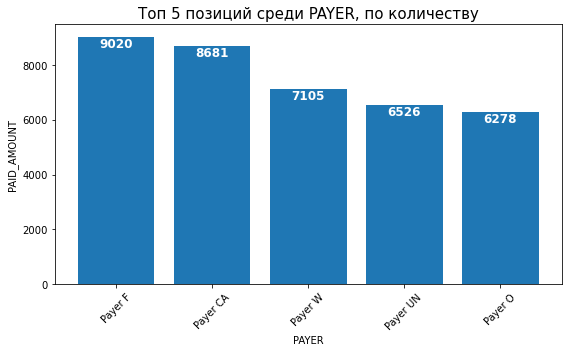

In [16]:
top_all(df, 'PAYER', 'count', 5)

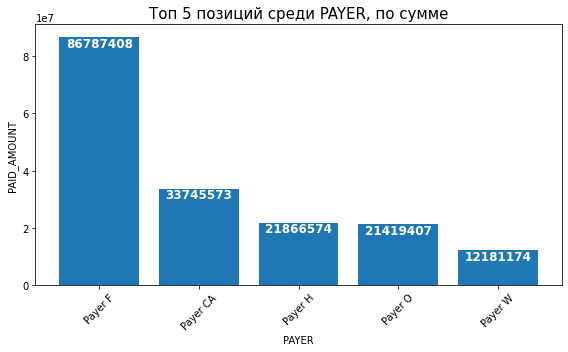

In [17]:
top_all(df, 'PAYER', 'sum', 5)

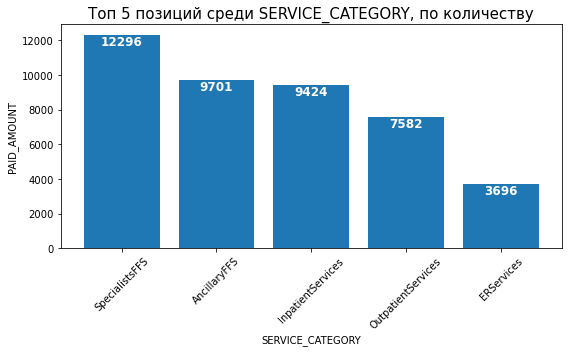

In [18]:
top_all(df, 'SERVICE_CATEGORY', 'count', 5)

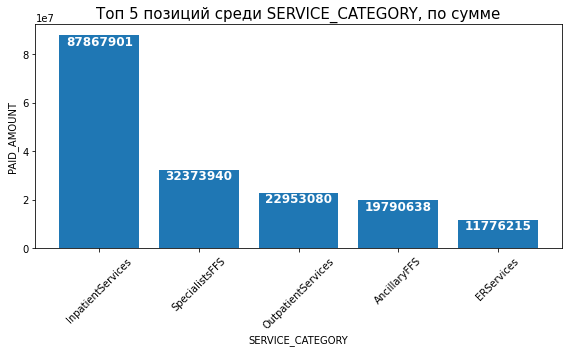

In [19]:
top_all(df, 'SERVICE_CATEGORY', 'sum', 5)

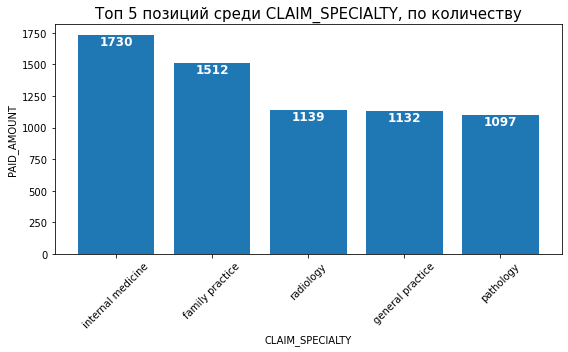

In [20]:
top_all(df, 'CLAIM_SPECIALTY', 'count', 5)

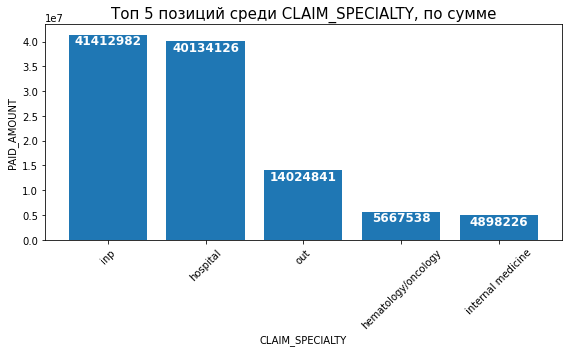

In [21]:
top_all(df, 'CLAIM_SPECIALTY', 'sum', 5)

### Общие продажи по месяцам

In [22]:
payments_by_time = df.groupby('MONTH')['PAID_AMOUNT'].agg(['count', 'sum'])
payments_by_time.T

MONTH  2018-01-01  2018-02-01  2018-03-01  2018-04-01  2018-05-01  2018-06-01  \
count        1712        1664        1723        1714        1759        1745   
sum       6977385     6441297     6453429     6772445     6947634     5899749   

MONTH  2018-07-01  2018-08-01  2018-09-01  2018-10-01  ...  2019-10-01  \
count        1706        1775        1767        1748  ...        1863   
sum       5889255     6326764     5900700     7175764  ...     7160429   

MONTH  2019-11-01  2019-12-01  2020-01-01  2020-02-01  2020-03-01  2020-04-01  \
count        1723        1772        1782        1711        1769        1539   
sum       6728624     6673909     7464570     6463730     6550948     4988126   

MONTH  2020-05-01  2020-06-01  2020-07-01  
count        1668        1344          67  
sum       5426762     2913437      130410  

[2 rows x 31 columns]

In [23]:
def sales_general (titel_add = ''):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    if titel_add == '':
        titel_text = 'График суммы и количества платежей по месяцам'
        data = df.groupby('MONTH')['PAID_AMOUNT'].agg(['count', 'sum'])  
    else:
        titel_text = 'График суммы и количества платежей по месяцам, в рамках {}'.format(titel_add)
        data = df[df.SERVICE_CATEGORY == titel_add]
        data = data.groupby('MONTH')['PAID_AMOUNT'].agg(['count', 'sum'])  
          
    plt.title(titel_text, fontsize = 15)
    ax1.plot(data.index, data['sum'], label='Сумма платежей', marker='o', color = 'black')
    ax1.set_xlabel('Месяц')
    ax1.set_ylabel('Сумма платежей')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.plot(data.index, data['count'], label='Количество платежей', marker='x')
    ax2.set_ylabel('Количество платежей')
    ax2.tick_params(axis='y')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='lower left')

    plt.show()

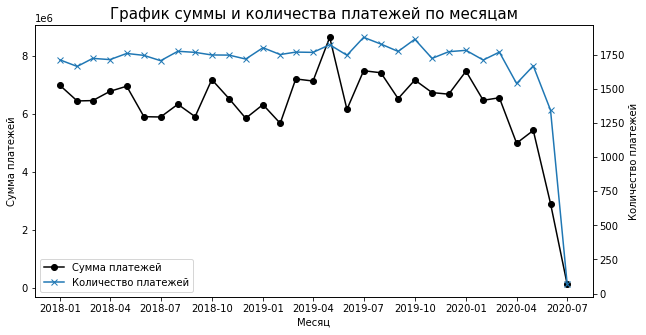

In [24]:
sales_general()

<b>Уже видно что в 2020 году сумма выплат существенно падает до своего минимума в июле 2020. Хотелось бы узнать у продактов, что было с продуктом в с апреля 2020 года. Здесь явно какое-то большое общее событие.

<b>Это общий. Рассмотрим в рамках категории сервиса.

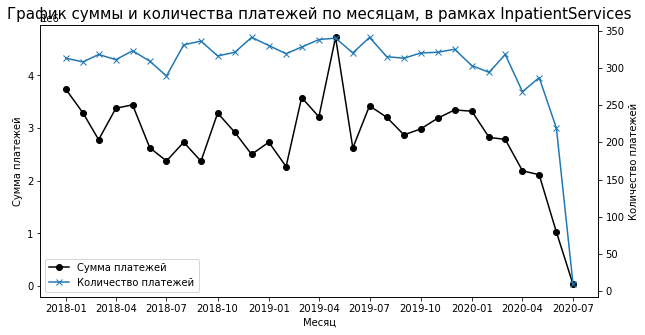

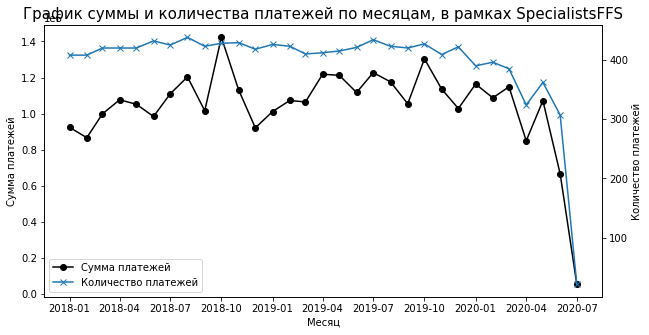

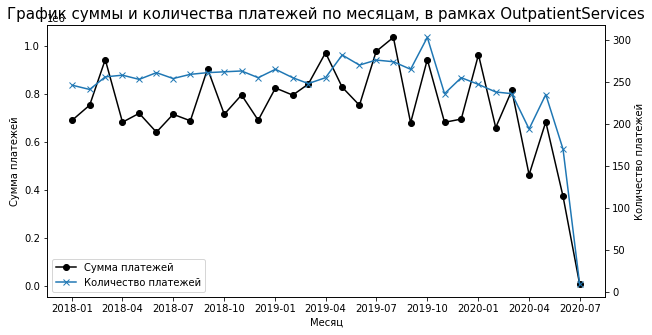

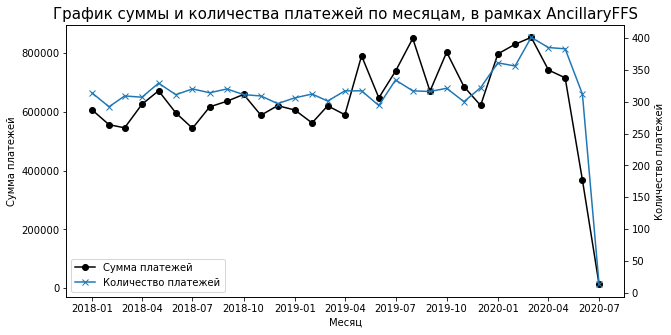

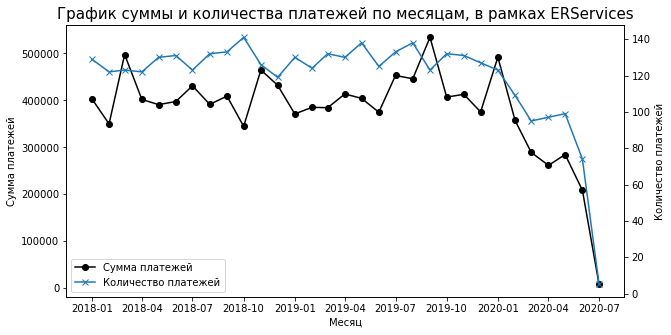

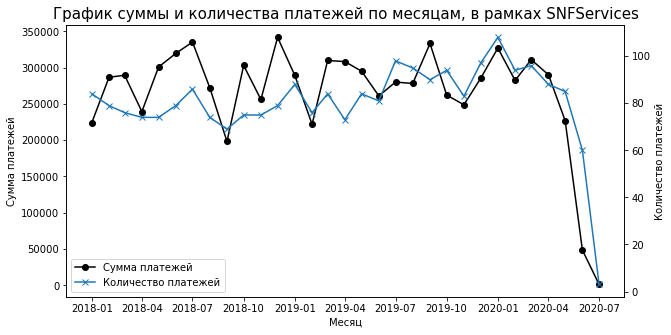

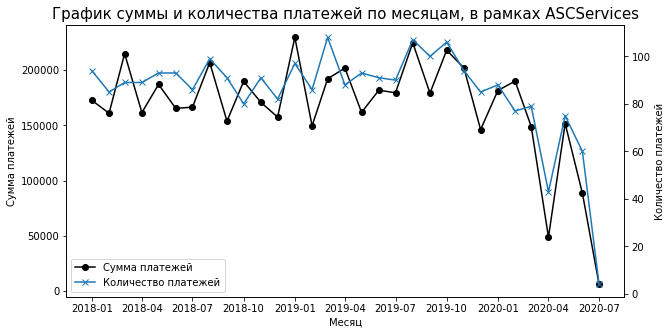

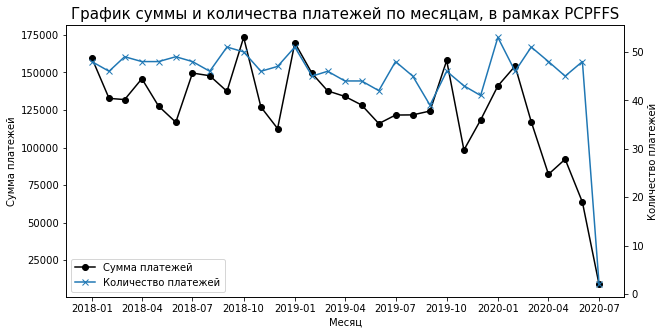

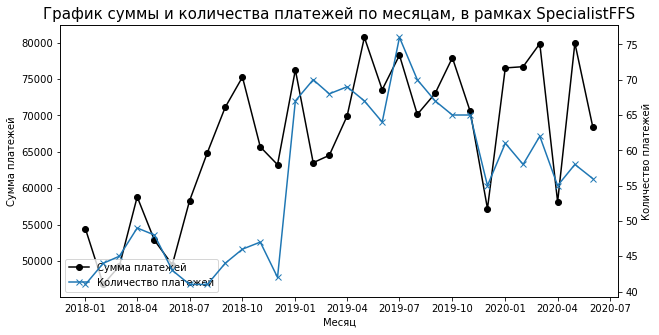

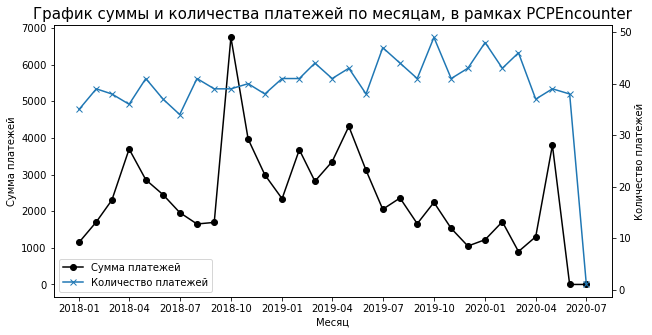

In [25]:
for category in top_all(df, 'SERVICE_CATEGORY', 'sum', 10,  True).SERVICE_CATEGORY.values:
    sales_general(category)

<b>Разбирая данные по отдельным сервисам мы уже видим три тенденции:
<ul>
<li>Из всех сервисов только один SpecialistFFS остался на нормальном уровне активности. Но он второй с конца по фин показателям и не аффектит нас значительно.
<li>Несмотря на общее падение в районе апреля, при детальном рассмотрении выявлено, что значительная часть сервисов начали свой тренд по уменьшению фин показателей с февраля.
<li>Несколько сервисов, такие как Ancillary, SNFService и PCPEncounter начали выраженное падение только в мае.
<li>Так-же, видна доп закономерность, что после падения статистик в апреле произошел отскок и повышение фин показателей мае. Этот отскок выразился дополнительными пиками или замедлением падения. Не знаю что там произошло, но эти действия хорошо повлияли на активность клиентов.

<b>Рассмотрим в рамках клиентов.

In [26]:
def sels_by_clients (type_agg):
    if type_agg == 'count':
        title = 'Количество оплат по клиентам'
        axe = 'Количество оплат'
    else:
        title = 'Сумма оплат по клиентам'
        axe = 'Сумма оплат'
    fig, ax1 = plt.subplots(figsize=(12, 6))
    for client in top_all(df, 'PAYER', 'count', 10, True).PAYER.values:
        plt.plot(df.loc[df.PAYER == client, ['MONTH','PAID_AMOUNT']].groupby('MONTH').agg(type_agg), label = client)
    plt.title(title, fontsize = 15)
    plt.xlabel('Месяц')
    plt.ylabel(axe)
    plt.legend()
    plt.show()

In [27]:
def sels_by_clients_sep (type_agg):
    for client in top_all(df, 'PAYER', type_agg, 10, True).PAYER.values:
        if type_agg == 'count':
            title = 'Количество оплат по клиенту: {}'.format(client)
            axe = 'Количество оплат'
        else:
            title = 'Сумма оплат по клиенту: {}'.format(client)
            axe = 'Сумма оплат'
        fig, ax1 = plt.subplots(figsize=(8, 4))
        plt.plot(df.loc[df.PAYER == client, ['MONTH','PAID_AMOUNT']].groupby('MONTH').count())
        plt.title(title, fontsize = 15)
        plt.xlabel('Месяц')
        plt.ylabel(axe)
        plt.show()

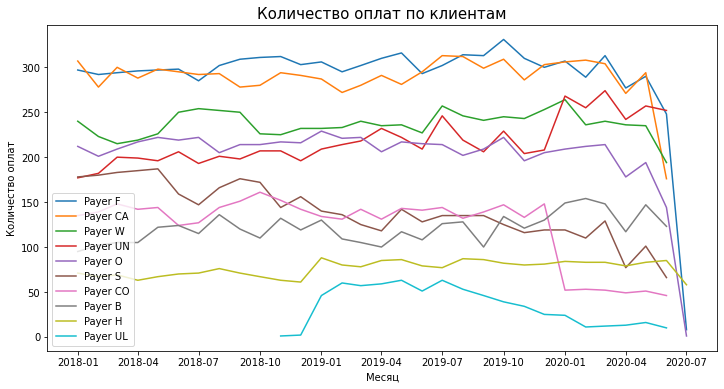

In [28]:
sels_by_clients('count')

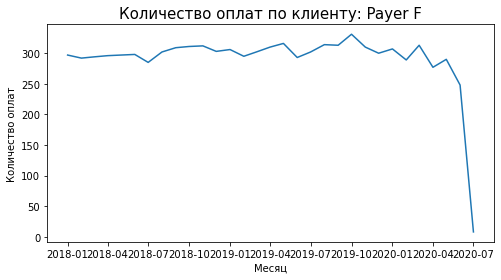

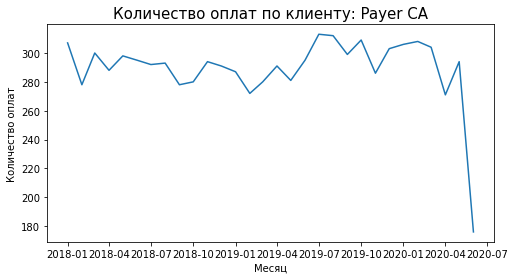

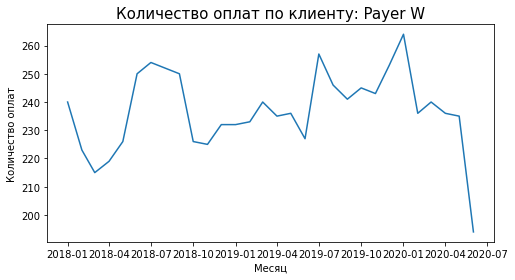

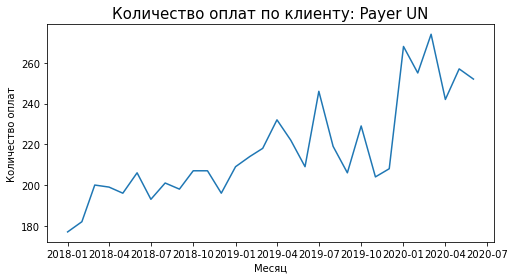

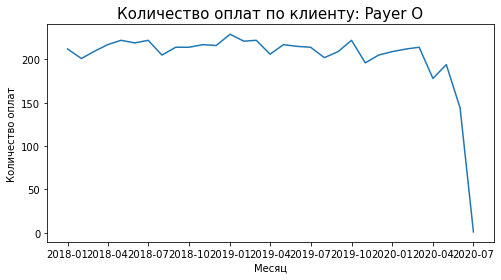

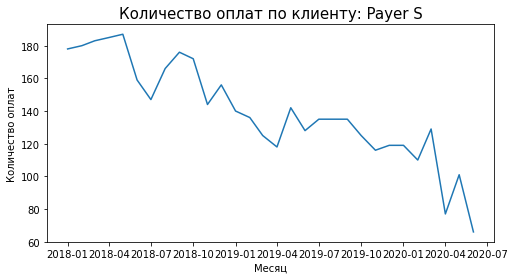

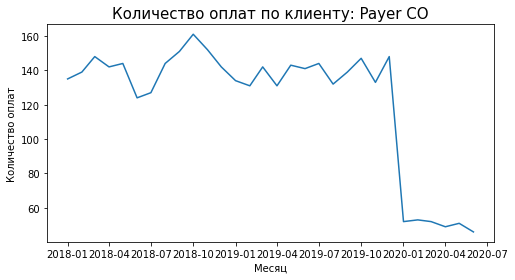

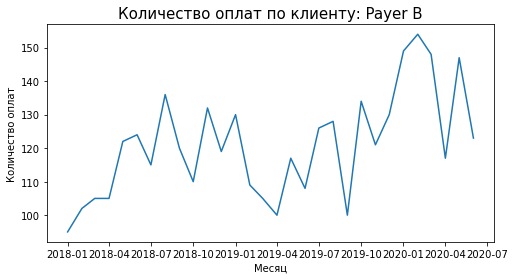

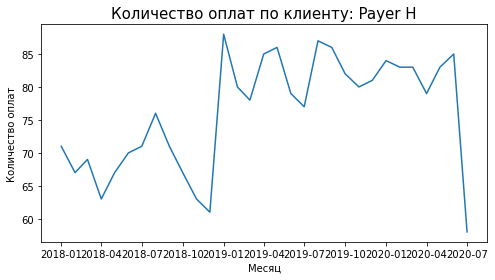

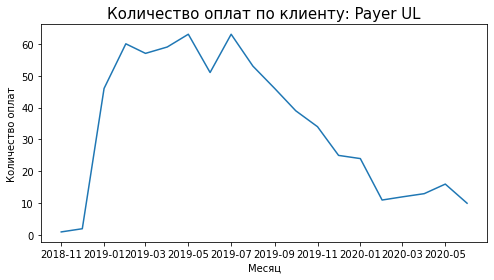

In [29]:
sels_by_clients_sep('count')

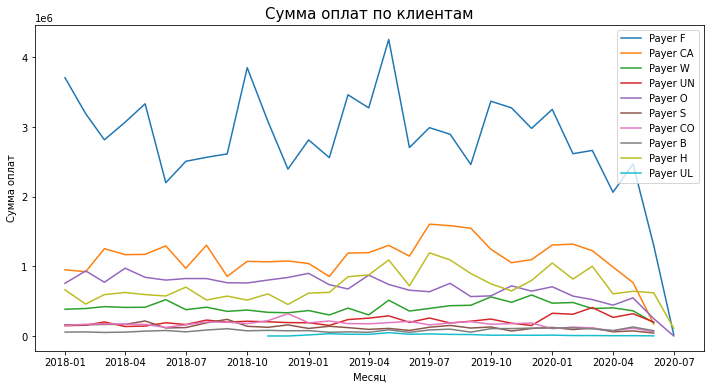

In [30]:
sels_by_clients('sum')

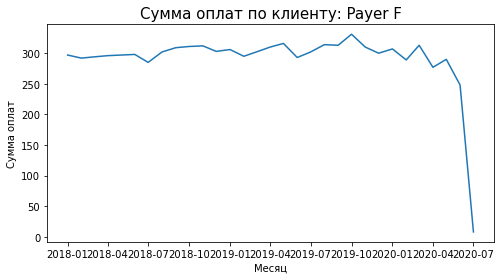

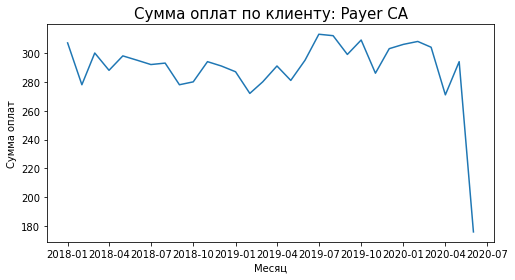

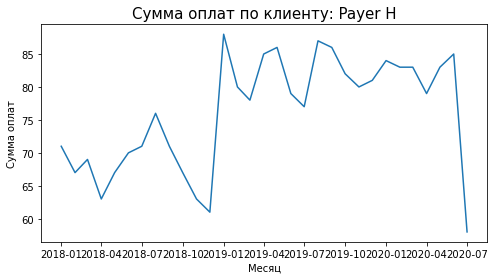

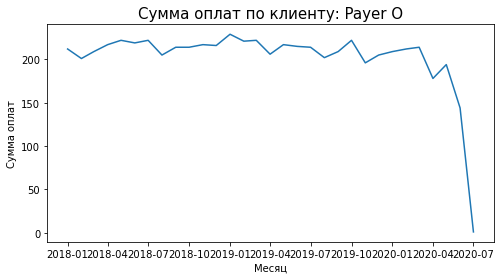

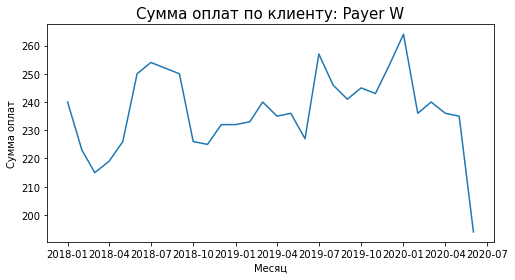

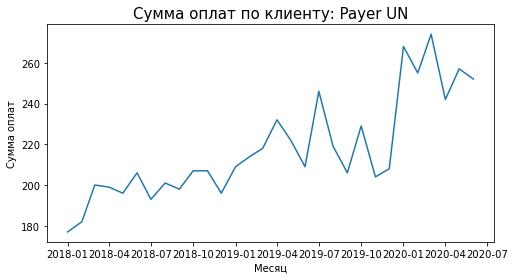

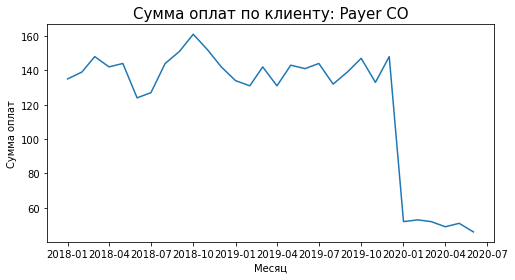

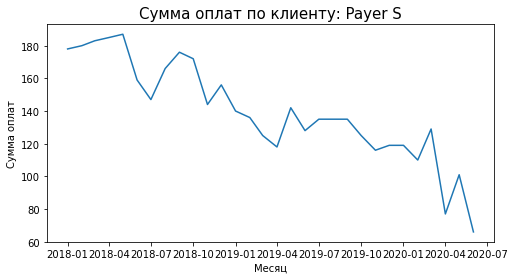

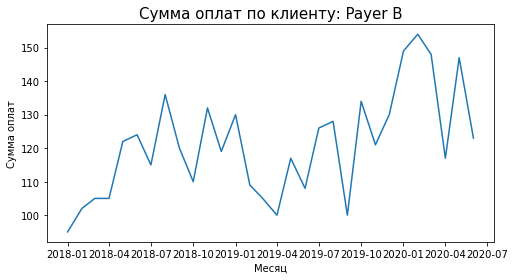

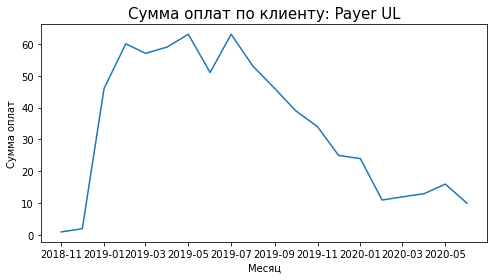

In [31]:
sels_by_clients_sep('sum')

<b>Только три клиента дожили до последнего месяца.

In [32]:
df[df.MONTH == '2020-07-01 00:00:00'].groupby('PAYER')['PAID_AMOUNT'].agg(['count', 'sum'])

count     sum
PAYER                 
Payer F      8   19899
Payer H     58  110406
Payer O      1     105

<b>Разбирая клиентские истории можно сделать выводы:
<ul>
<li>До общего обвала у большинства клиентов была стабильная прямая или растущая динамика. Включая ключевую пятерку. Но плательщики O, S, CO и UL показывали общее направления на спад задолго до начала конца.
<li>Самая лучшая динамика в рост наблюдалась у клиентов W, UN, B и H.
<li>В последнем месяце наблюдений платили только три клиента: F, H и O 


<b>По этим данным нельзя посчитать удержание, отток или когорты. Все клиенты стабильны на всем периоде наблюдений.

<b>LTV клиента

In [33]:
main_ltv = df.groupby('PAYER')['PAID_AMOUNT'].sum().mean()
print('Общий LTV = {}'.format(main_ltv))

Общий LTV = 19415639.6


LTV по источникам

In [34]:
res = {'service':[], 'LTV':[]}
for serv in top_all(df, 'SERVICE_CATEGORY', 'count', 20, True)['SERVICE_CATEGORY'].values:
    tmp_df = df[df.SERVICE_CATEGORY == serv]
    tmp_ltv = tmp_df.groupby('SERVICE_CATEGORY')['PAID_AMOUNT'].sum().mean()
    res['service'].append(serv)
    res['LTV'].append(tmp_ltv)
pd.DataFrame(res).sort_values(by = 'LTV', ascending = False)

service         LTV
2   InpatientServices  87867901.0
0      SpecialistsFFS  32373940.0
3  OutpatientServices  22953080.0
1        AncillaryFFS  19790638.0
4          ERServices  11776215.0
6         SNFServices   8226425.0
5         ASCServices   5192434.0
8              PCPFFS   3897810.0
7       SpecialistFFS   2005359.0
9        PCPEncounter     72594.0

<b>Показатель LTV соотносится по сервисам соотносятся с суммами полученными от сервисов. Тут нет чего-то нового.

<b>Посмотрим как соотносятся клиенты с источниками

In [35]:
df.groupby('SERVICE_CATEGORY')['PAYER'].nunique()

SERVICE_CATEGORY
ASCServices           10
AncillaryFFS          10
ERServices            10
InpatientServices     10
OutpatientServices    10
PCPEncounter          10
PCPFFS                10
SNFServices           10
SpecialistFFS          3
SpecialistsFFS         8
Name: PAYER, dtype: int64

In [36]:
arr = df[df.SERVICE_CATEGORY == 'SpecialistFFS']['PAYER'].unique()
print('Клиенты сервиса SpecialistFFS:', arr)

Клиенты сервиса SpecialistFFS: ['Payer F' 'Payer UN' 'Payer UL']


In [37]:
arr = df[df.SERVICE_CATEGORY == 'SpecialistsFFS']['PAYER'].unique()
print('Клиенты сервиса SpecialistsFFS:', arr)

Клиенты сервиса SpecialistsFFS: ['Payer CA' 'Payer F' 'Payer O' 'Payer CO' 'Payer W' 'Payer H' 'Payer S'
 'Payer B']


<b>Видно что только 2 источника не работают со всеми клиентами сразу. Это SpecialistFFS
и SpecialistsFFS. Причем SpecialistFFS - второй по прибыльности сервис с 3 клиентами, включая самого прибыльного F.

<b>Посмотрим какая часть плат клиентов уходит на какие сервисы

In [38]:
tmp_df = df.groupby(['PAYER','MONTH','SERVICE_CATEGORY'])['PAID_AMOUNT'].agg(['sum', 'count']).reset_index()
tmp_monh_agg = df.groupby(['PAYER','MONTH'])['PAID_AMOUNT'].agg(['sum', 'count']).reset_index()
tmp_all = pd.merge(tmp_df, tmp_monh_agg, on=['PAYER', 'MONTH'], how='inner', suffixes = ['_splited', '_solid'])

In [39]:
tmp_all['sum_part'] = tmp_all.sum_splited / tmp_all.sum_solid
tmp_all['count_part'] = tmp_all.count_splited / tmp_all.count_solid

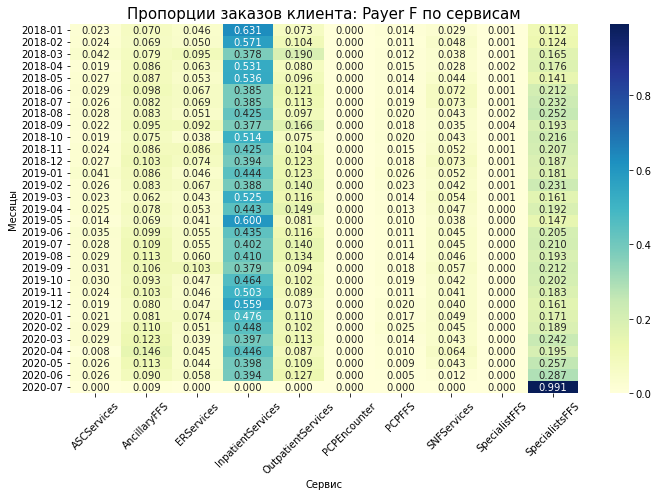

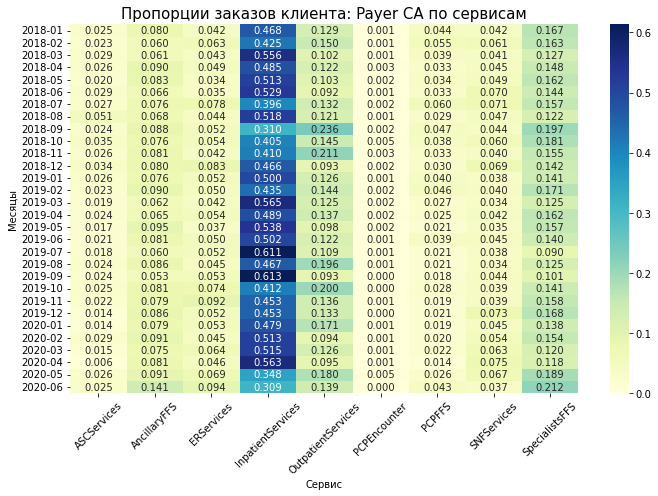

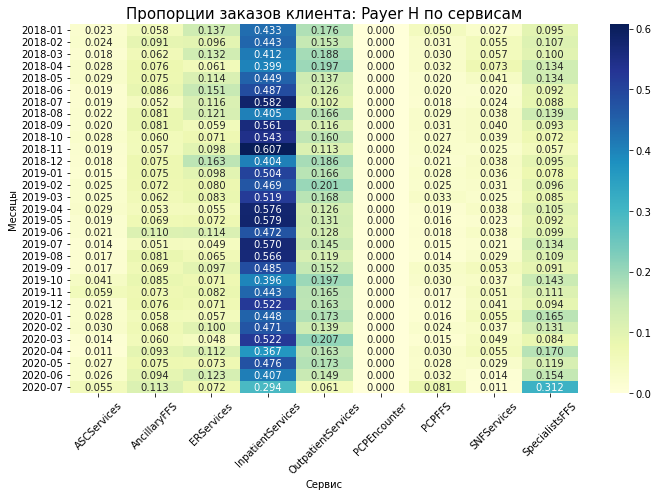

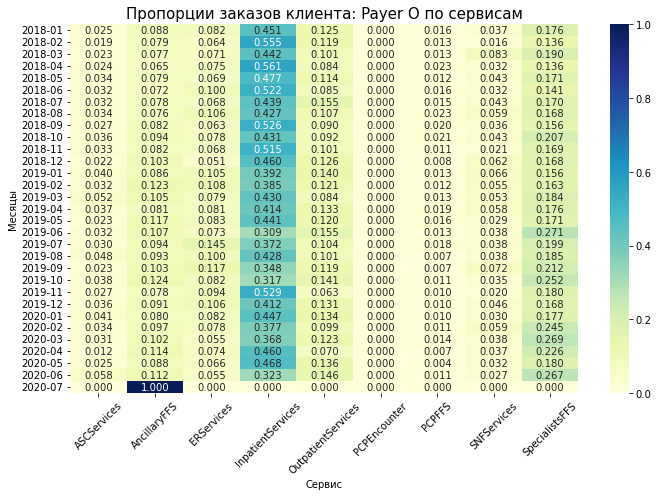

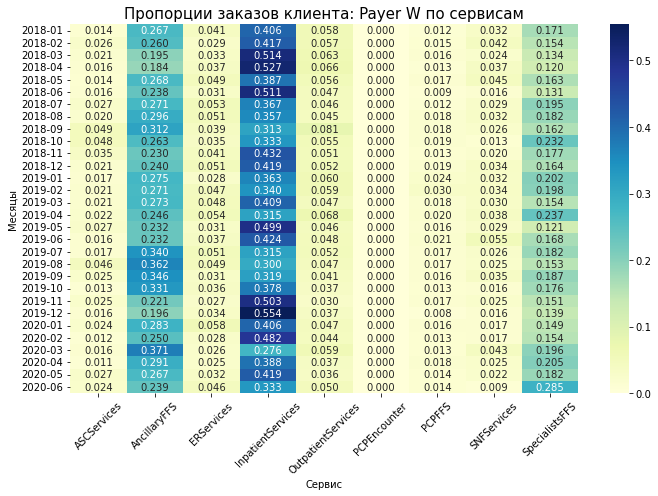

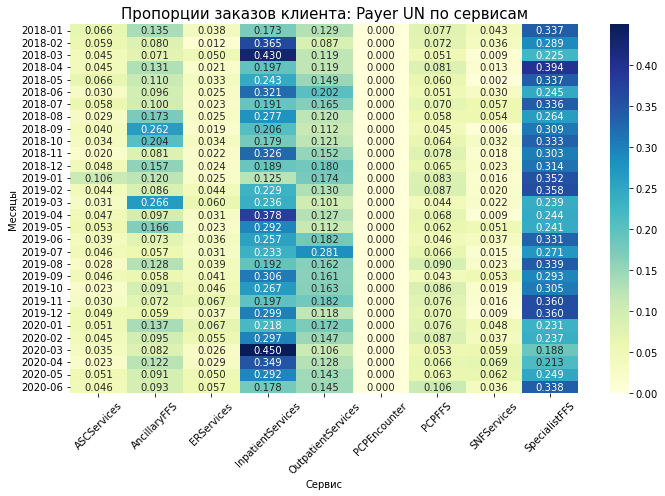

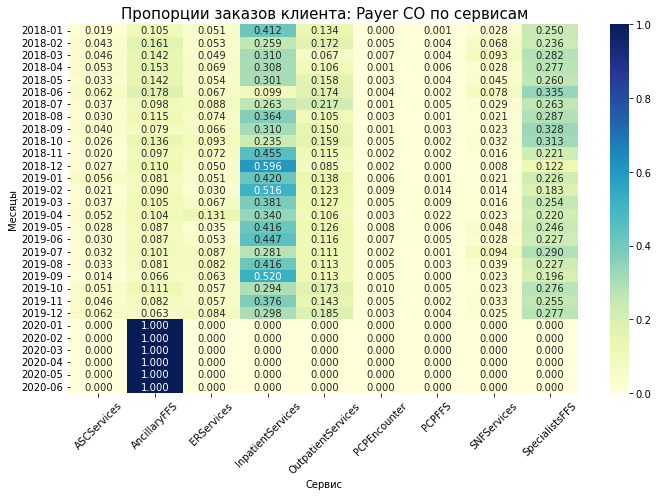

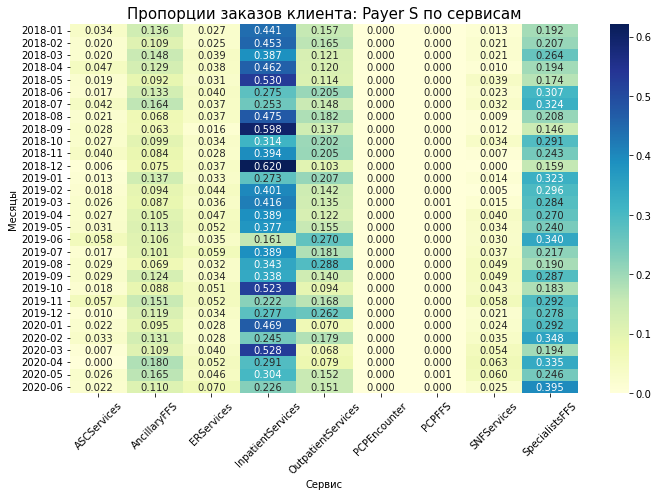

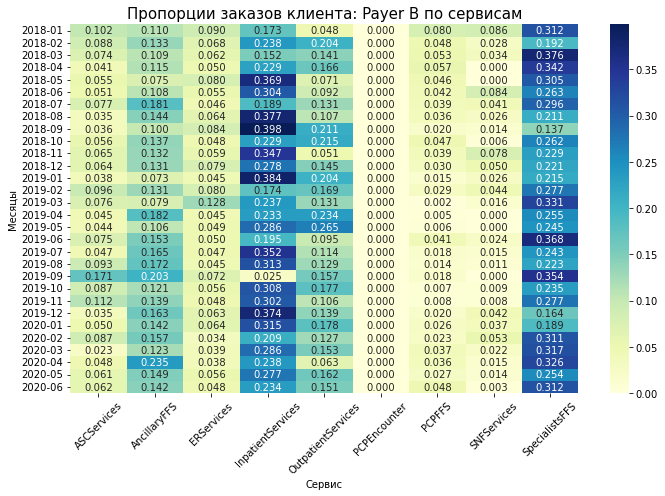

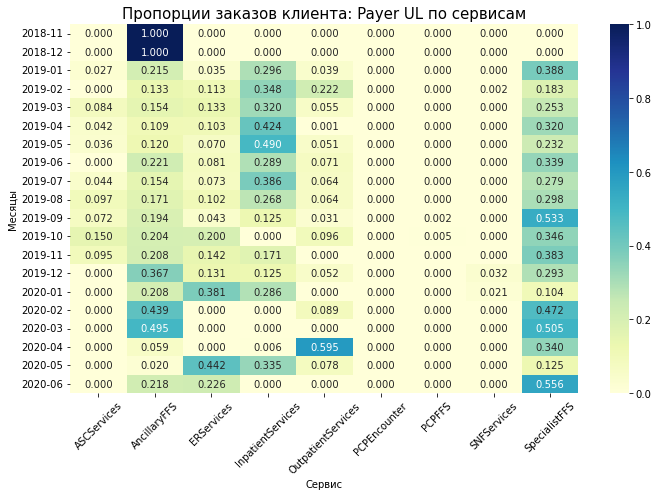

In [40]:
for client in top_all(df, 'PAYER', 'sum', 20, True).PAYER.values:
    t = tmp_all[tmp_all.PAYER == client].pivot_table(
        index = 'MONTH', 
        columns = 'SERVICE_CATEGORY', 
        values = 'sum_part', 
        aggfunc = 'sum'
    ).fillna(0)
    t.index = t.index.strftime('%Y-%m')
    
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(t.fillna(0), annot=True, fmt=".3f", cmap="YlGnBu")

    plt.title('Пропорции заказов клиента: {} по сервисам'.format(client) , fontsize = 15)
    plt.xlabel('Сервис')
    plt.ylabel('Месяцы')

    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

<b>В отношении объема целевых действий в сервисах:
<ul>
<li>Первые 4 по уровню платежей клиенты имеют один паттерн сервисов. Основная часть платежей следует через InpatientServices, OutpatientServices и SpecialistsFFS несут вторичную роль, остатки распространены по иным сервисам.
<li>У плательщика W основными сервисами являются InpatientServices и SpecialistsFFS, а место OutpatientServices занимает AncillaryFFS. каждый из сервисов несет в себе примерно треть сумм платежей.
<li>Для плательщика UN сервис SpecialistsFFS является ключевым. В остальном картина обычая.
<li>Плательщик СО имел обычную картину 2020 года, а там начал использовать только AncillaryFFS.
<li>Плательщики S и B используют SpecialistsFFS как основной сервис.
<li>Поведение плательщика UL хаотично. Не получается понять что он использует в первую или вторую очередь.

<b>Посмотрим на цены за специалистов

In [41]:
tmp_df = pd.DataFrame(df.groupby('CLAIM_SPECIALTY')['PAID_AMOUNT'].sum().sort_values(ascending = False))
tmp_df['cumsum'] = tmp_df.PAID_AMOUNT.cumsum()
tmp_df['part_of_total'] = tmp_df['cumsum'] / df.PAID_AMOUNT.sum()
test_df = tmp_df[tmp_df['part_of_total'] <= 0.8]
df_limeted = df[df.CLAIM_SPECIALTY.isin(test_df.index)]

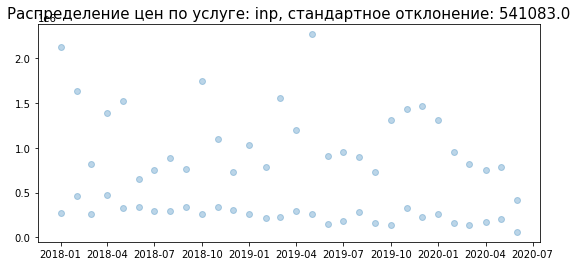

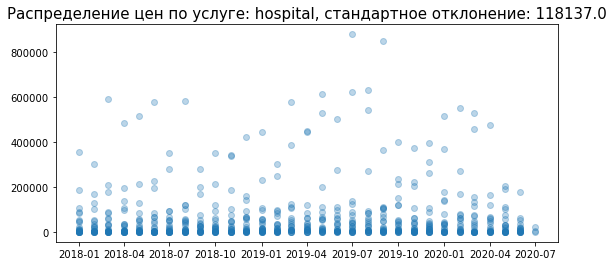

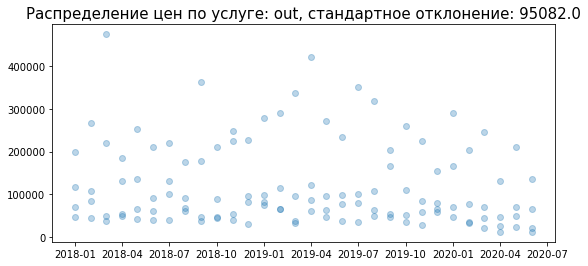

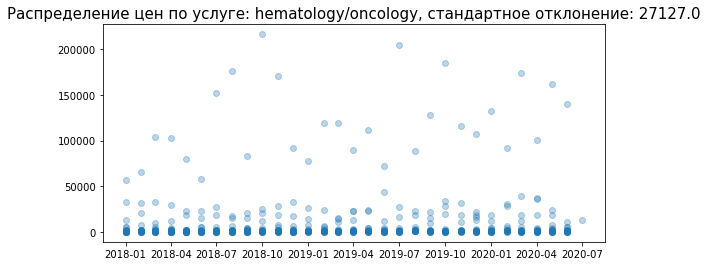

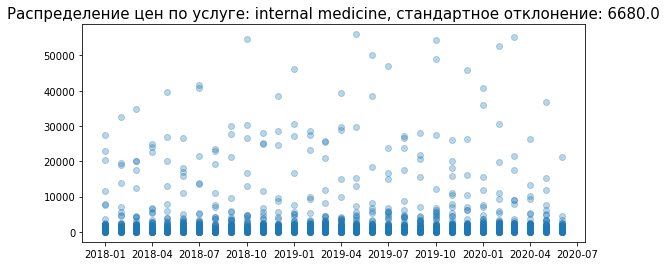

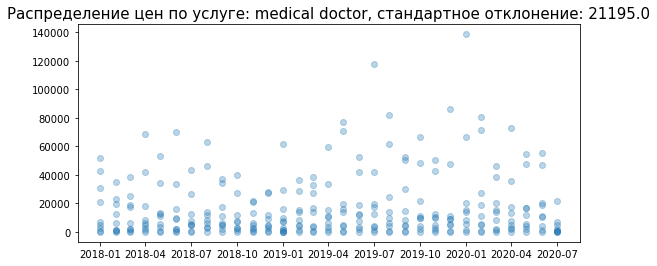

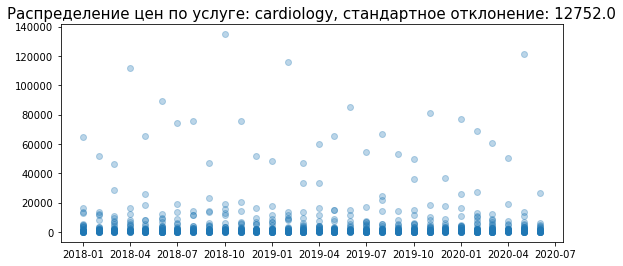

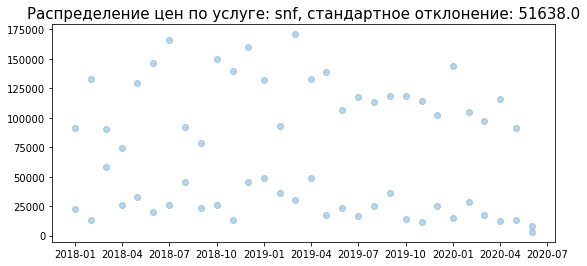

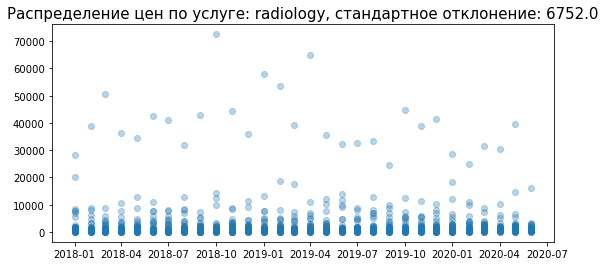

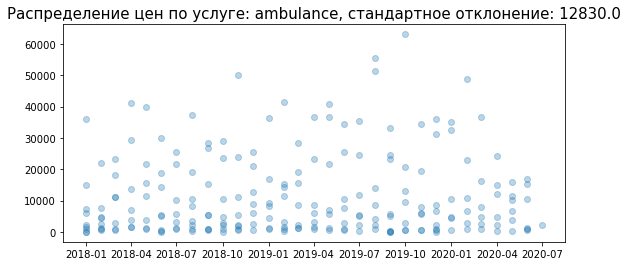

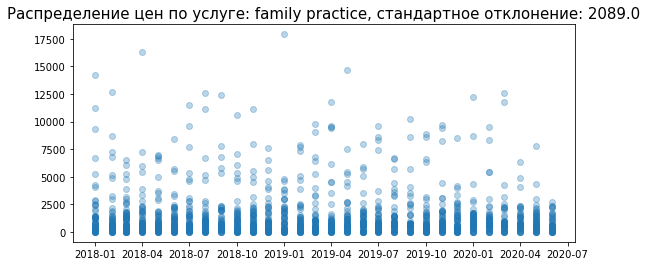

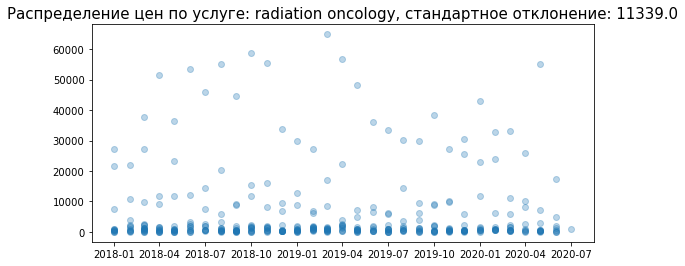

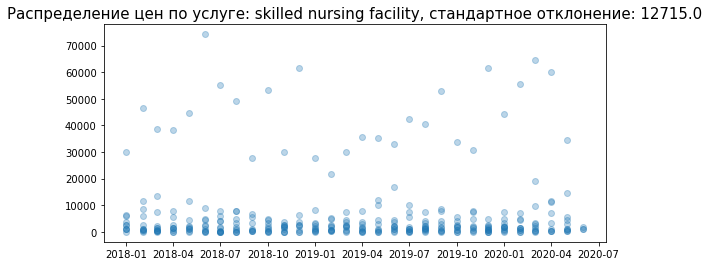

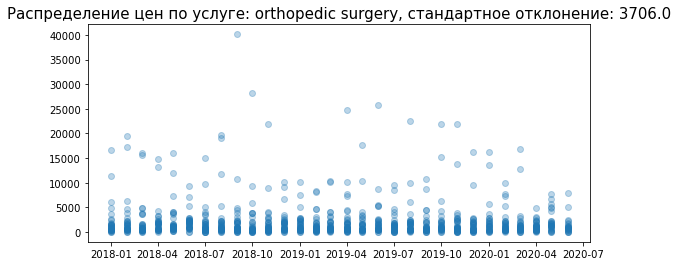

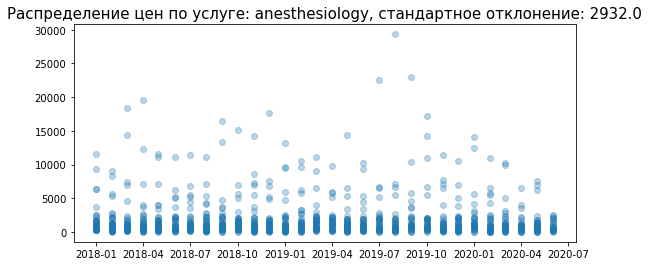

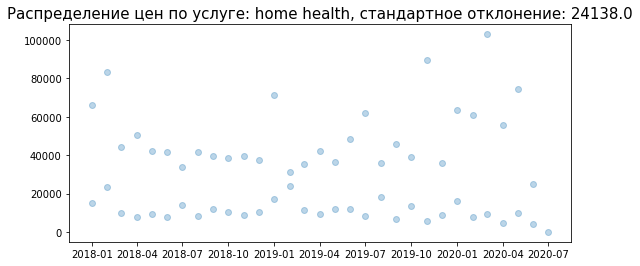

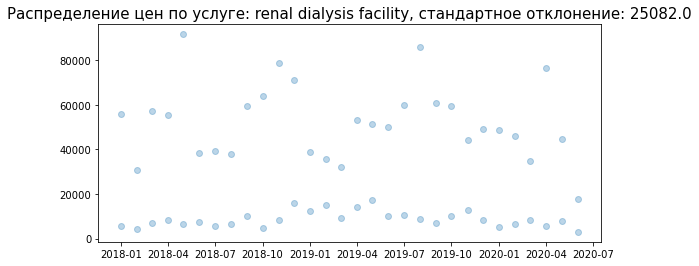

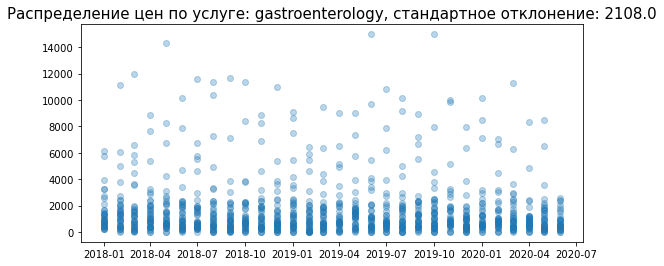

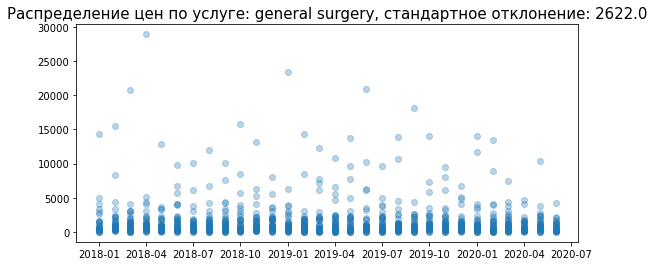

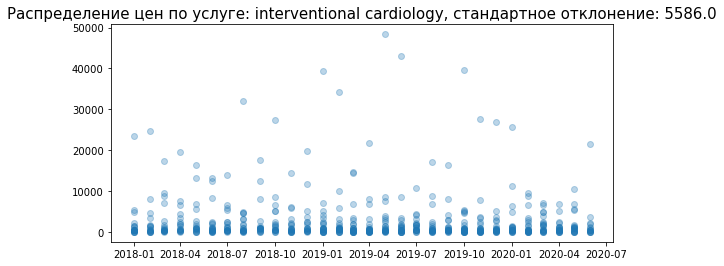

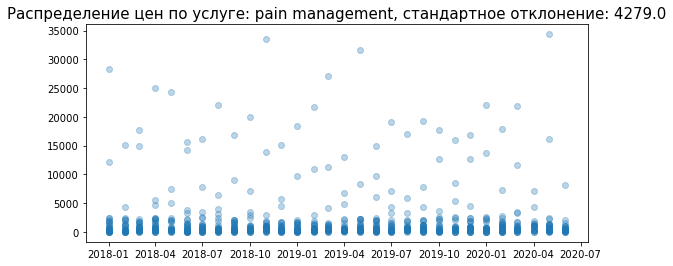

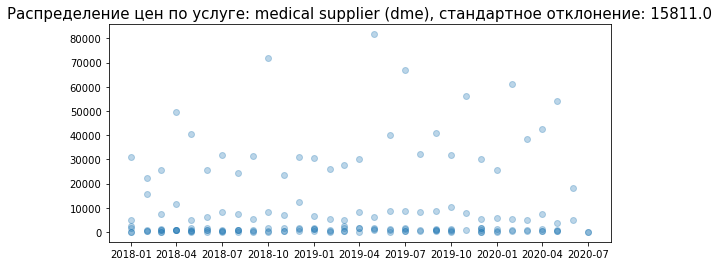

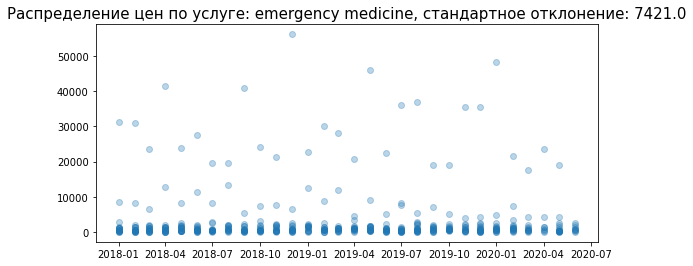

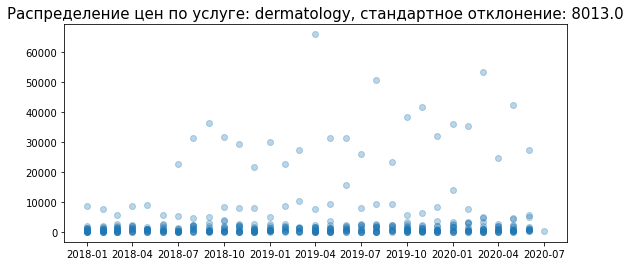

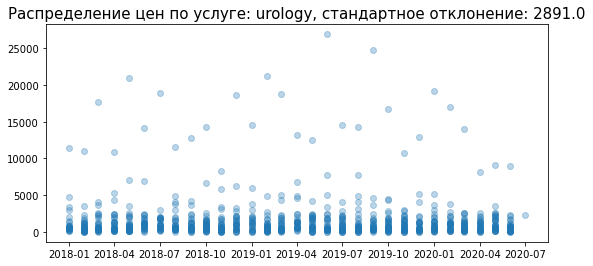

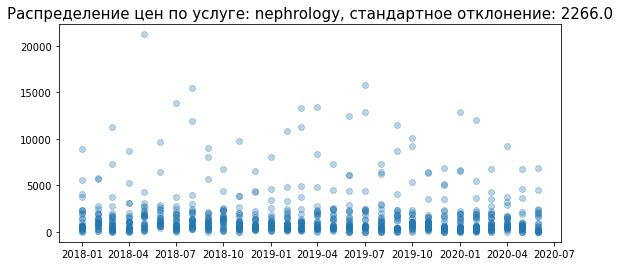

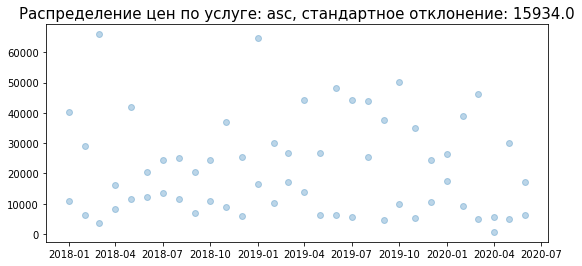

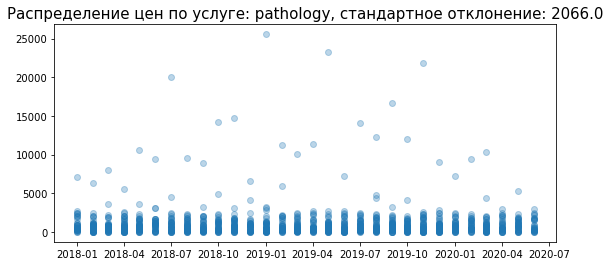

In [42]:
for spec in test_df.index:
    t = df_limeted[df_limeted.CLAIM_SPECIALTY == spec]
    payers = t.PAYER.unique()
    fig, ax = plt.subplots(figsize=(9, 4))
    plt.title('Распределение цен по услуге: {}, стандартное отклонение: {}'.format(spec, round(t.PAID_AMOUNT.std(),0)) 
              , fontsize = 15)
    ax.scatter(t.MONTH, t.PAID_AMOUNT, alpha=0.3)
    plt.show()

<b>Имеет смысл проверить услуги с наибольшим разбросом. Возьмем услуги с разбросом от 5000 долларов и проверим их по сервисам и клиентам.

In [43]:
std_df = df_limeted.groupby('CLAIM_SPECIALTY')['PAID_AMOUNT'].std()
limit2 = std_df[std_df >= 5000].sort_values(ascending = False).index
res_limit = df_limeted[df_limeted.CLAIM_SPECIALTY.isin(limit2)]

<b>По плательщикам

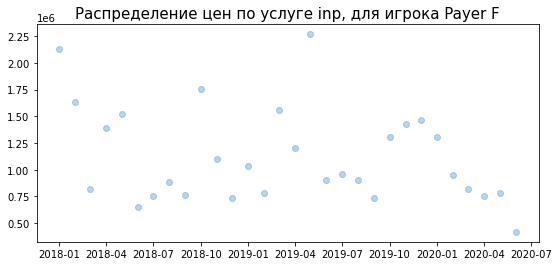

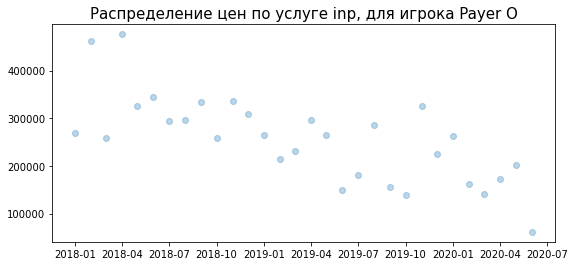

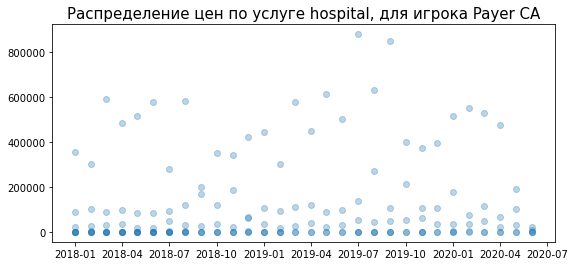

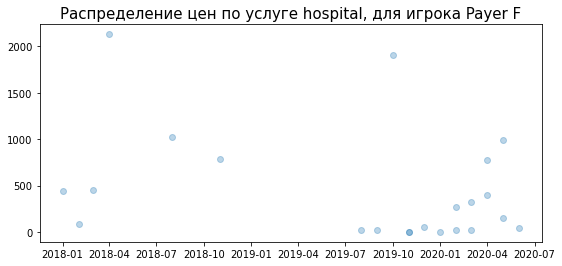

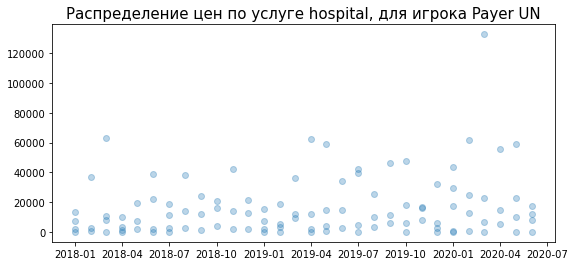

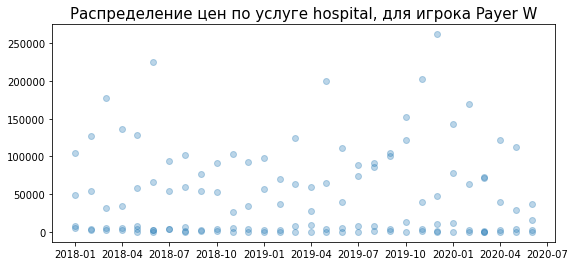

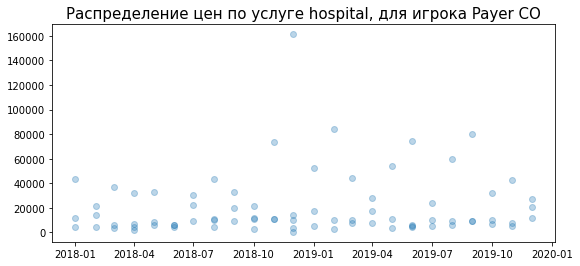

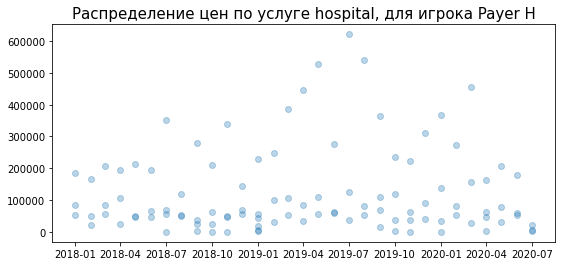

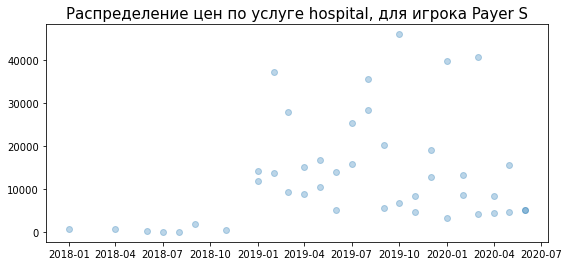

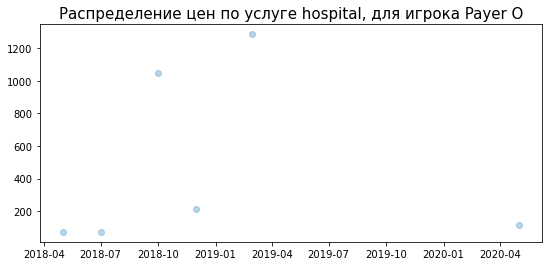

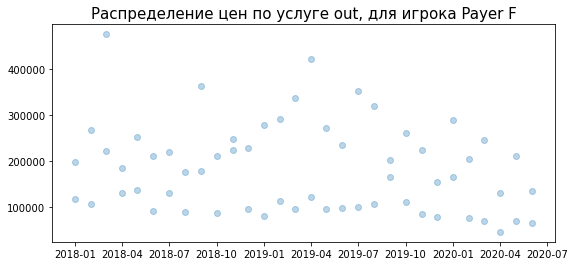

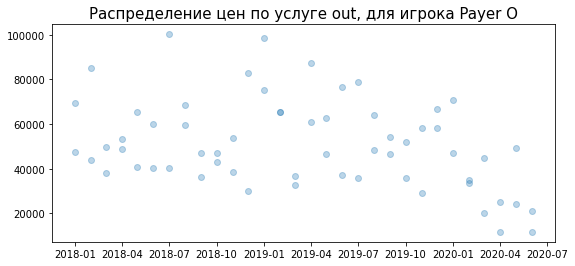

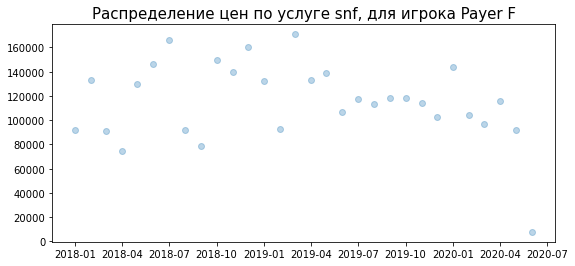

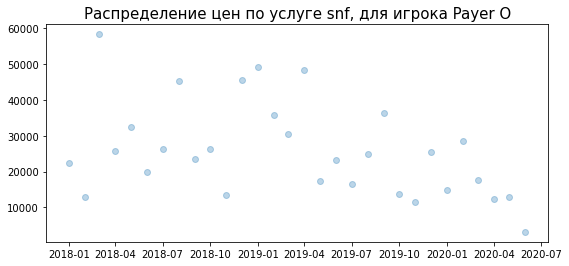

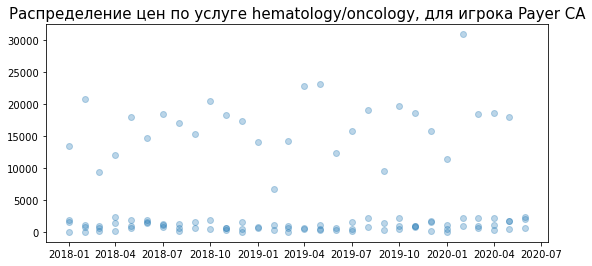

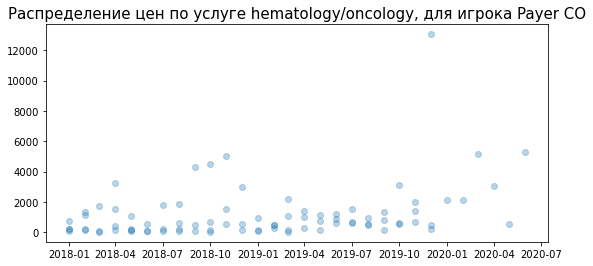

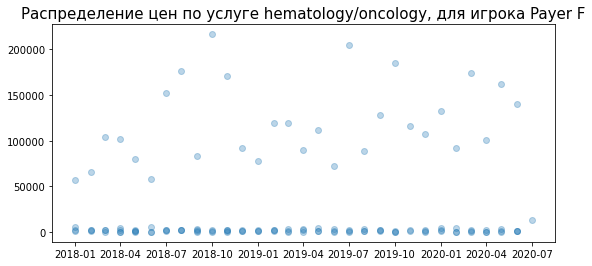

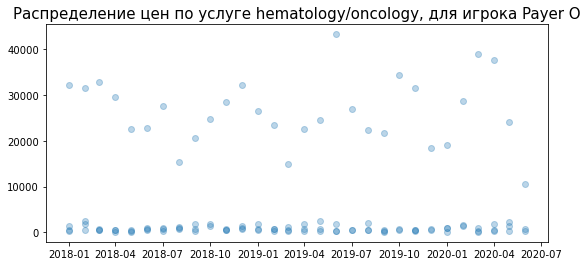

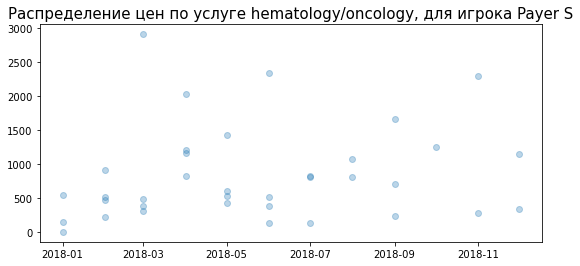

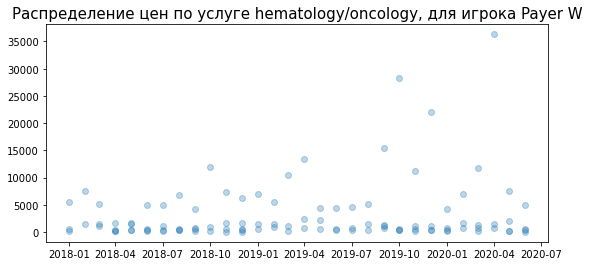

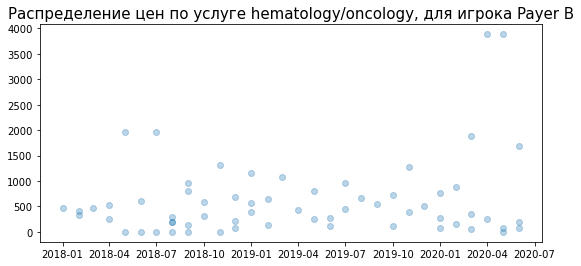

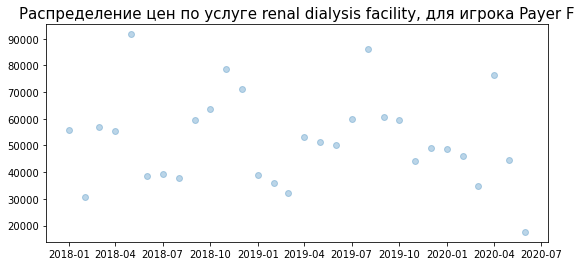

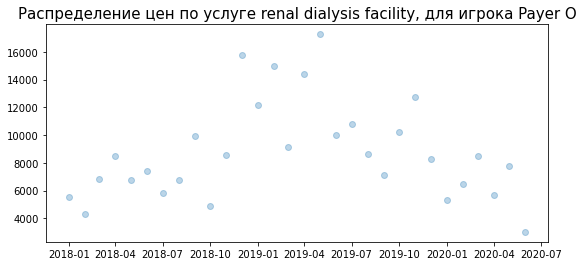

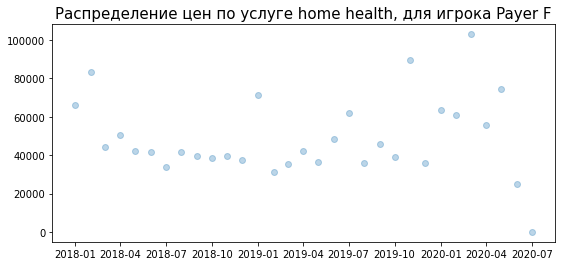

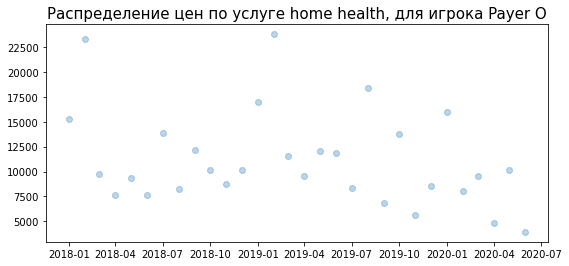

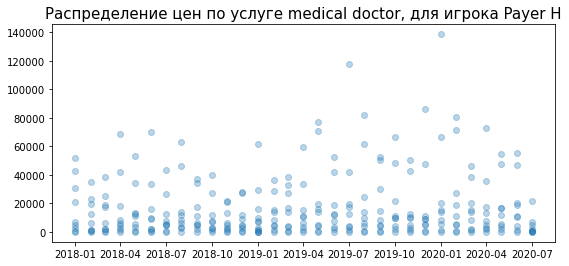

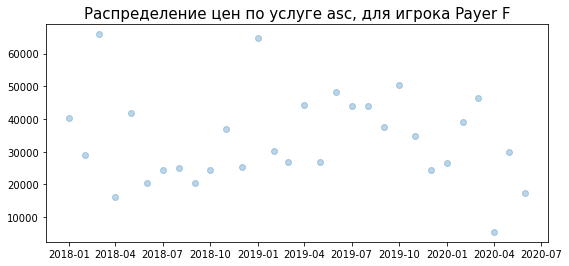

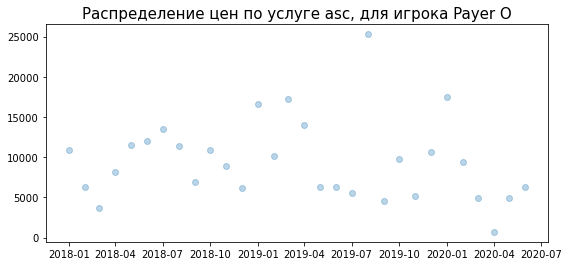

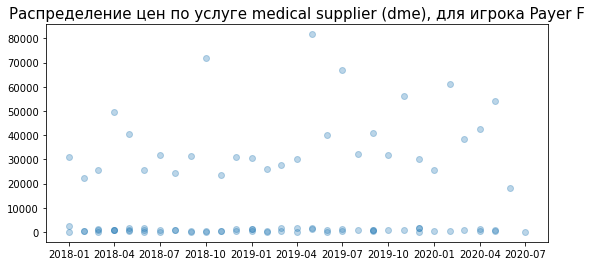

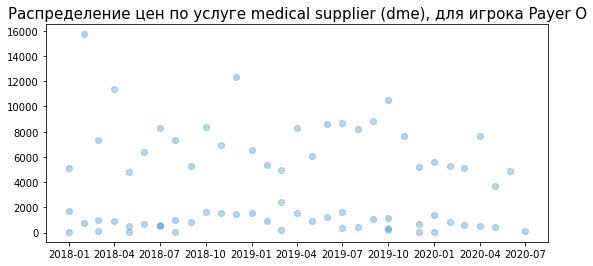

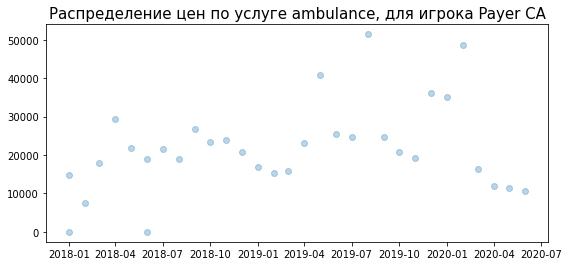

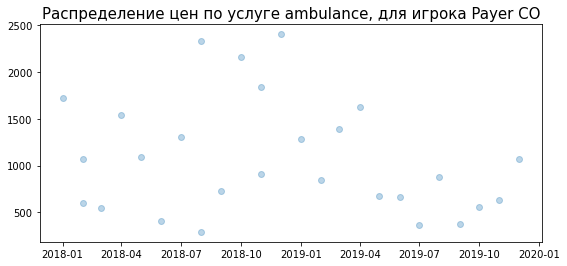

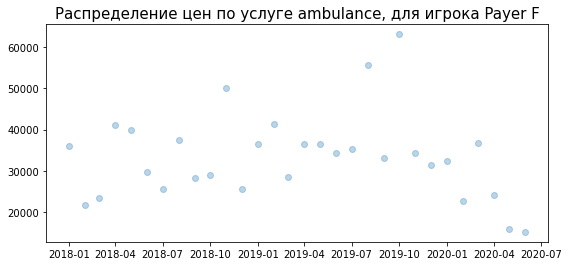

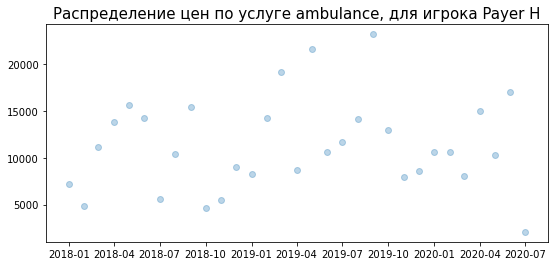

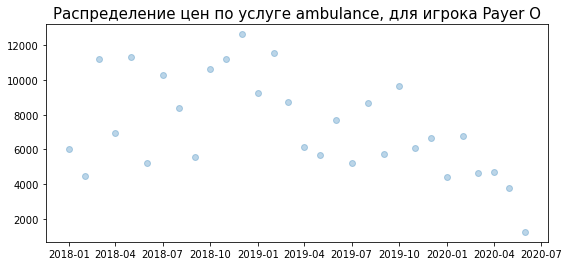

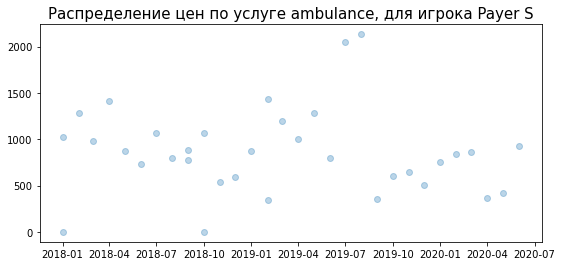

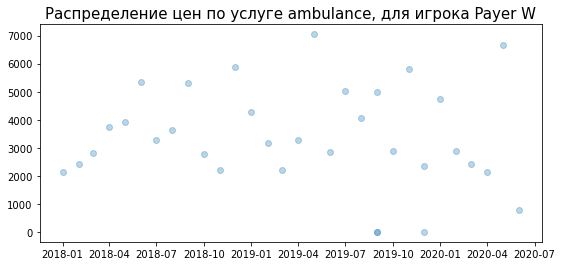

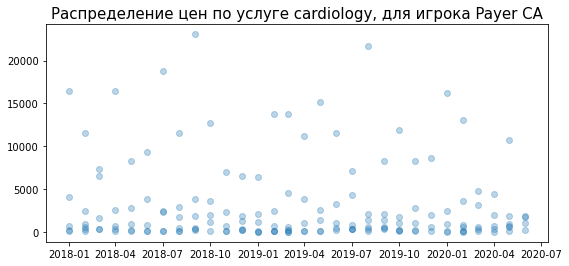

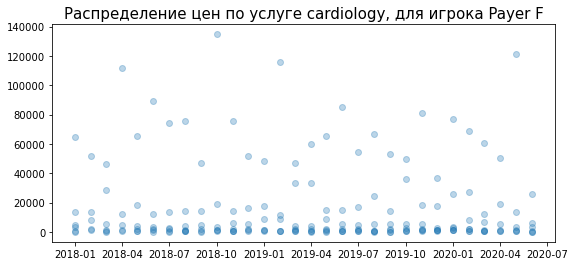

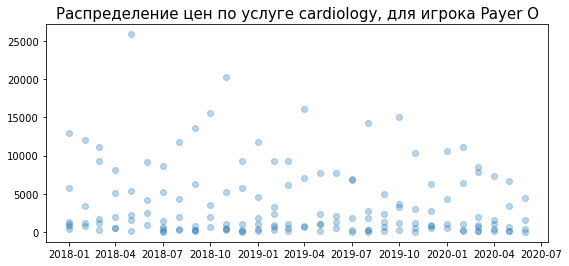

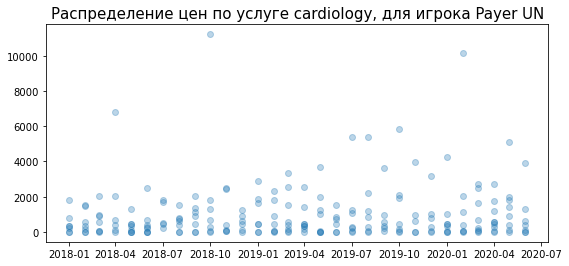

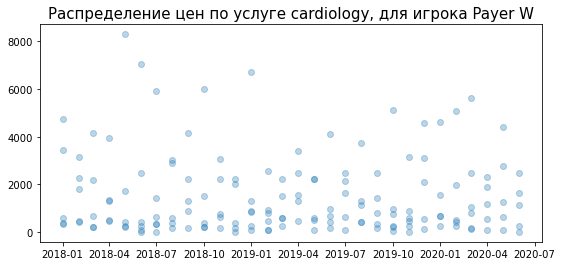

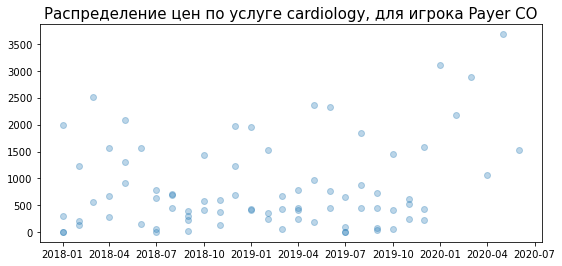

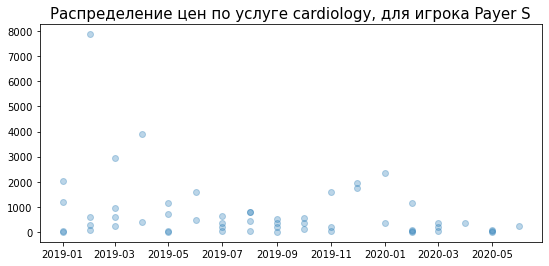

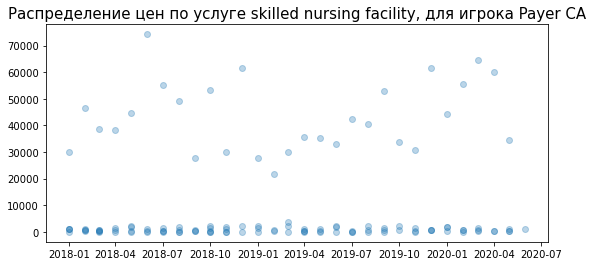

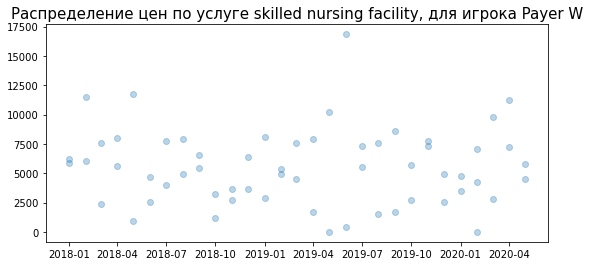

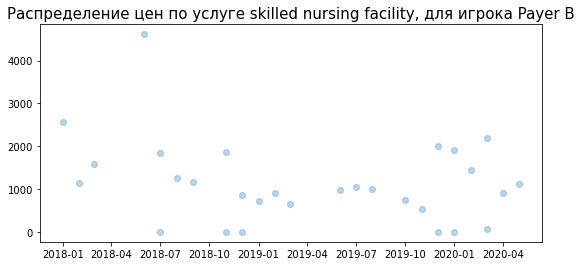

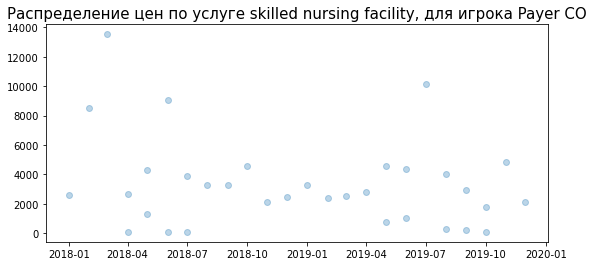

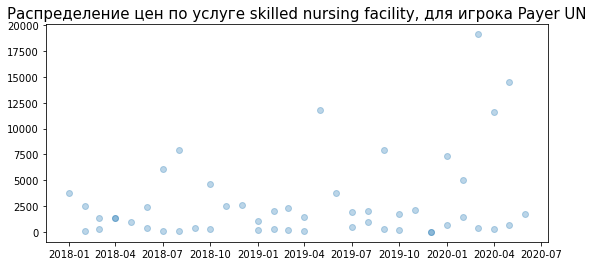

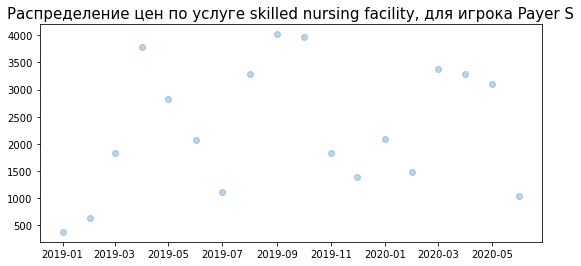

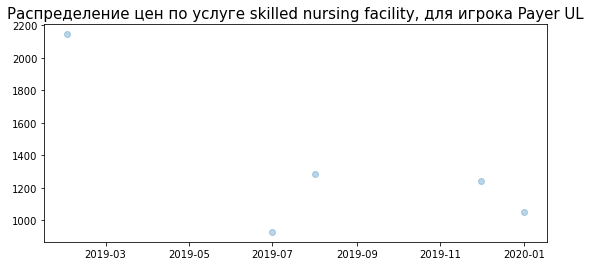

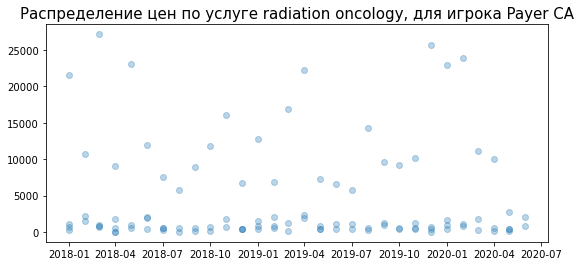

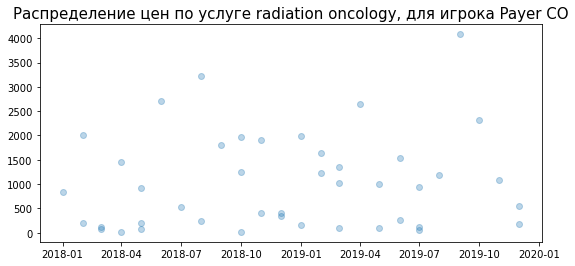

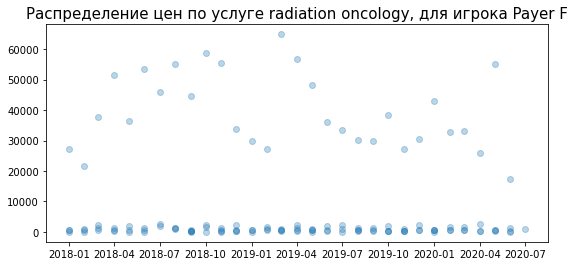

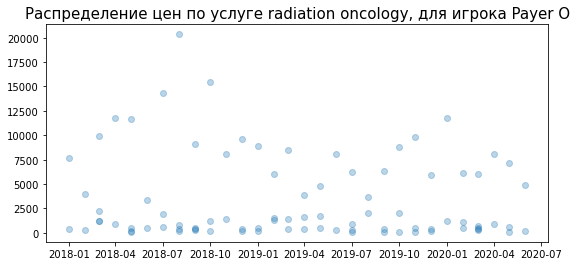

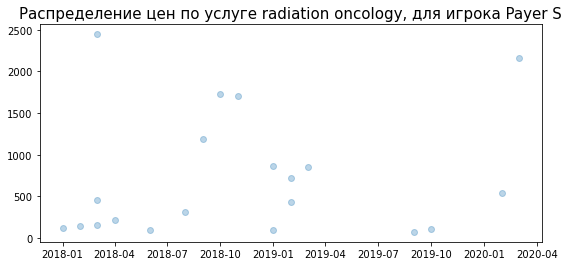

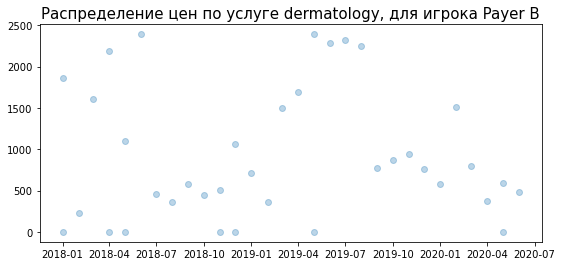

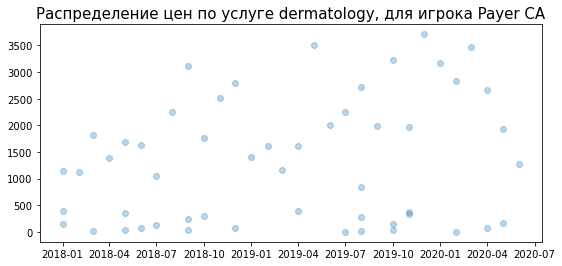

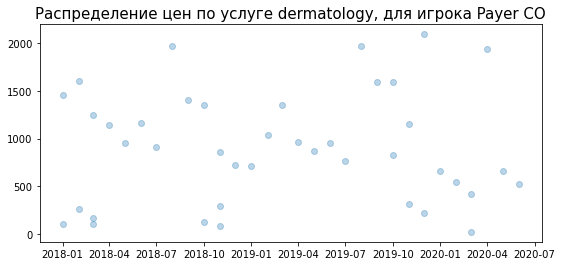

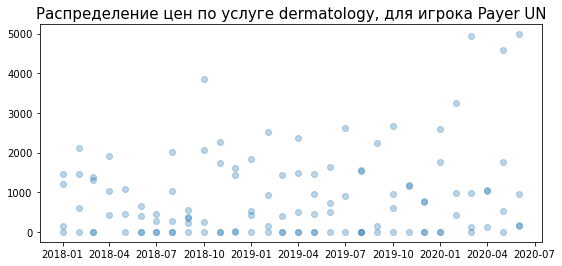

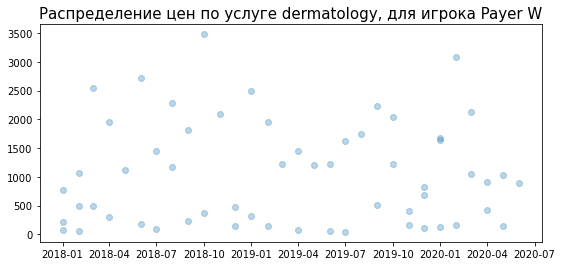

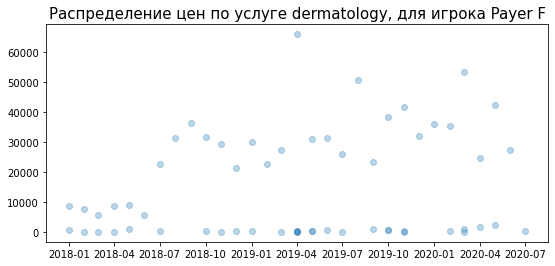

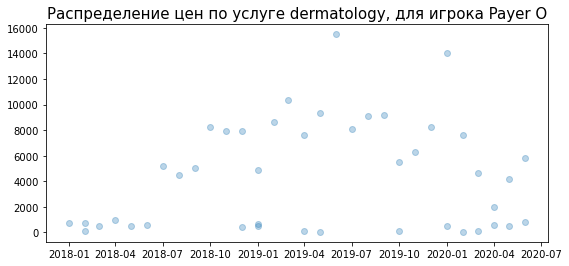

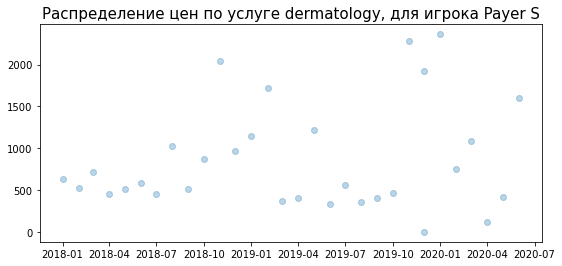

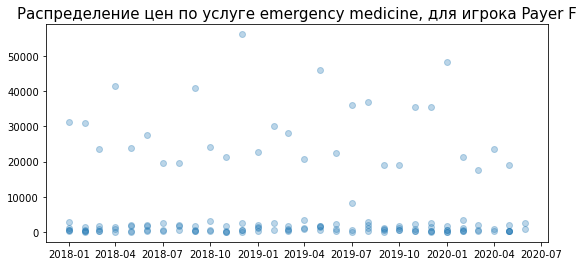

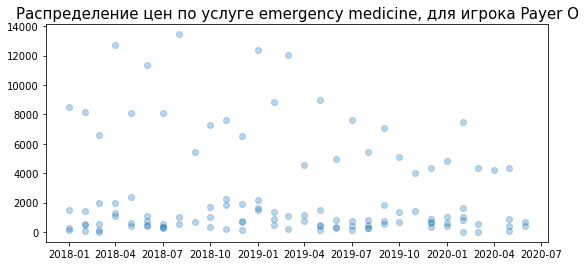

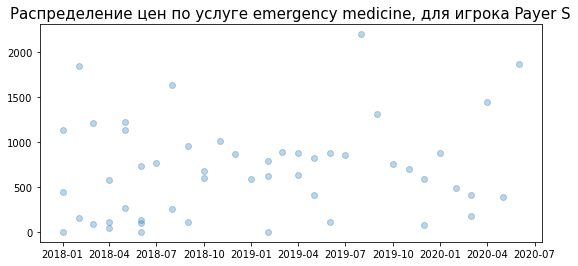

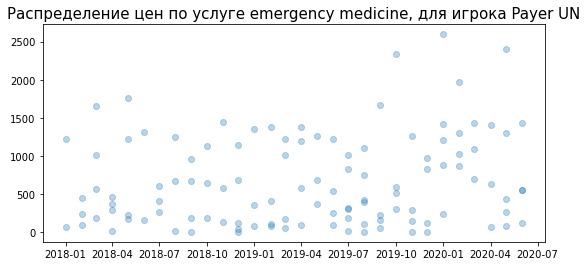

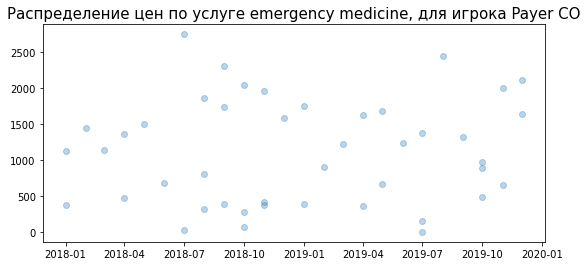

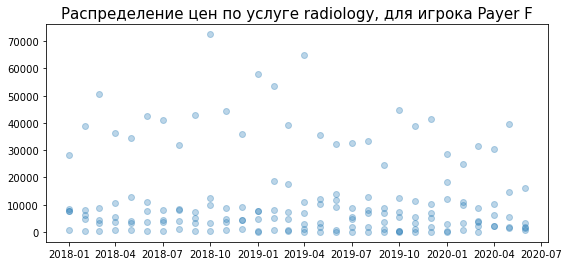

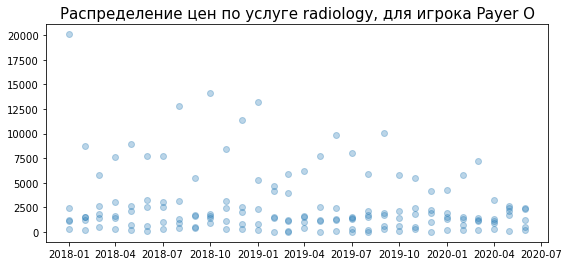

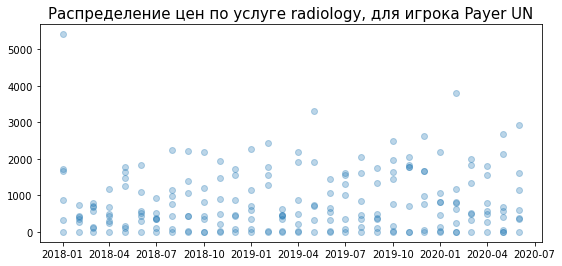

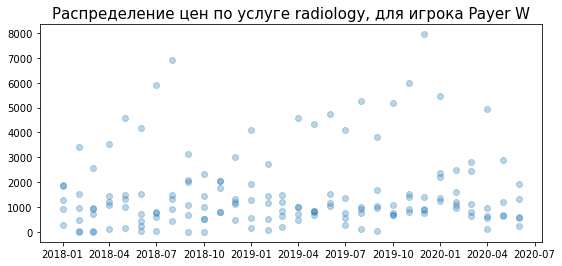

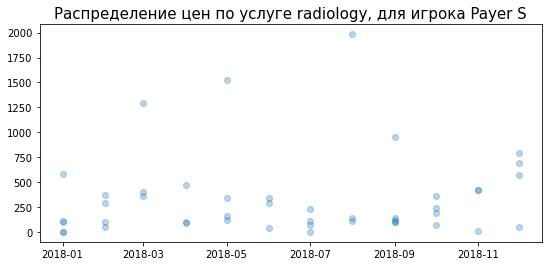

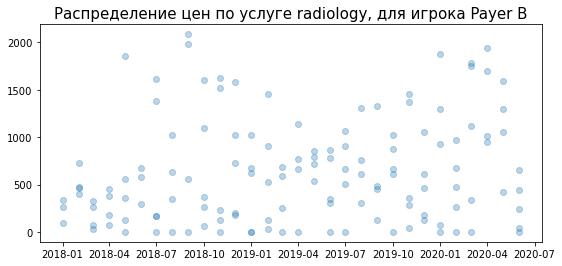

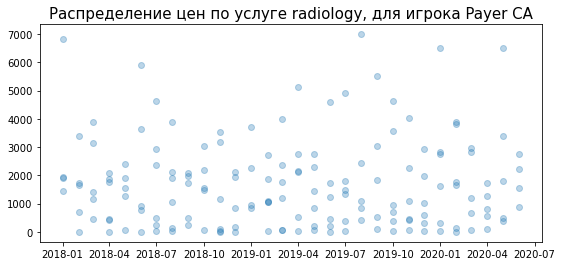

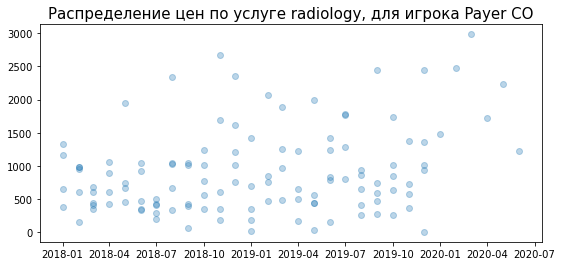

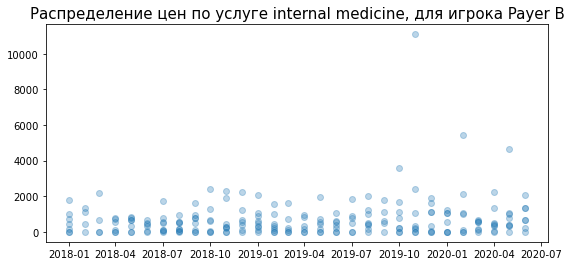

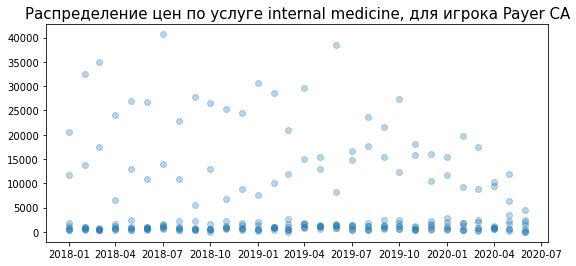

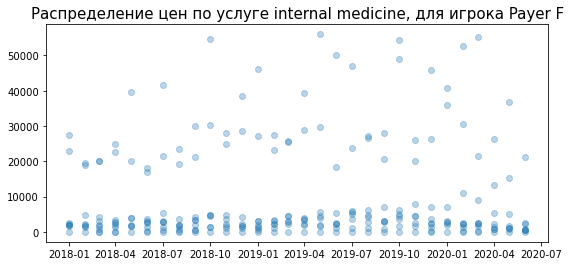

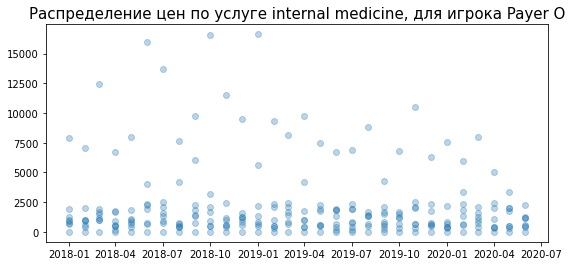

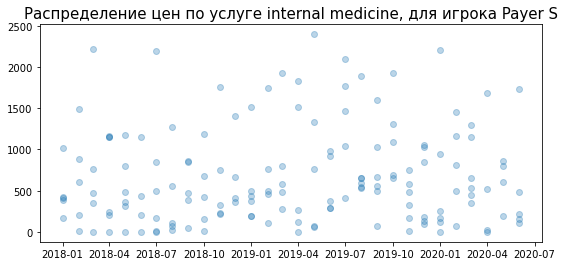

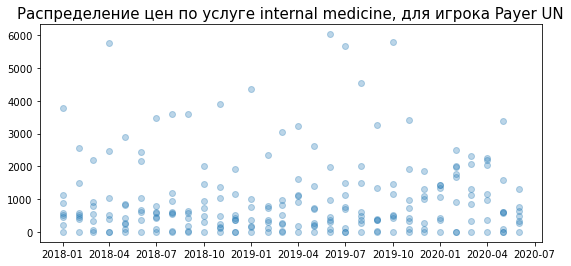

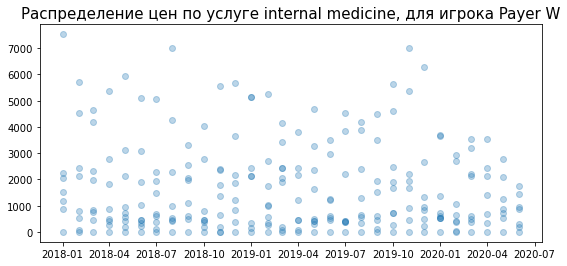

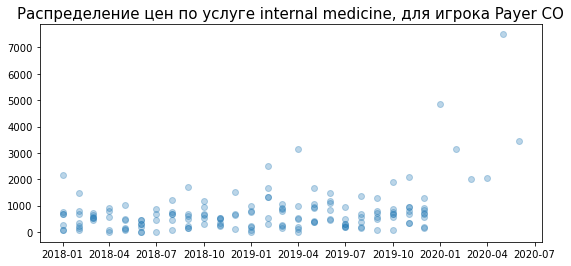

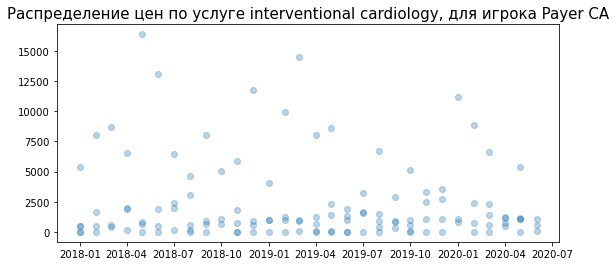

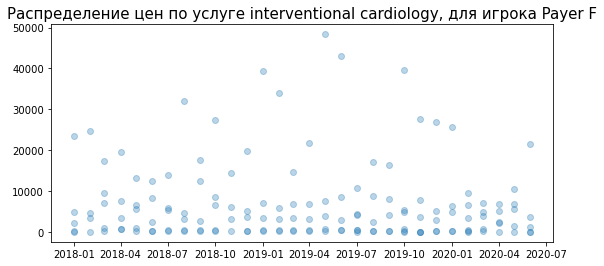

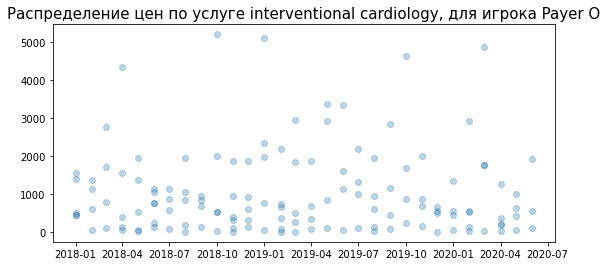

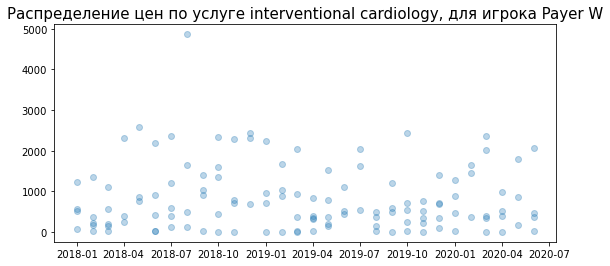

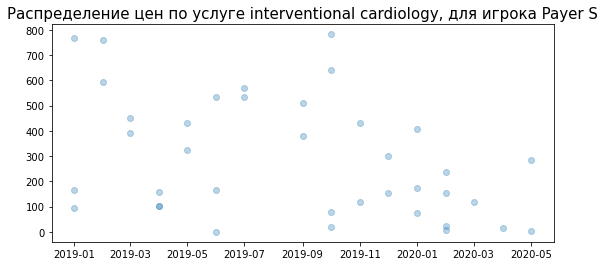

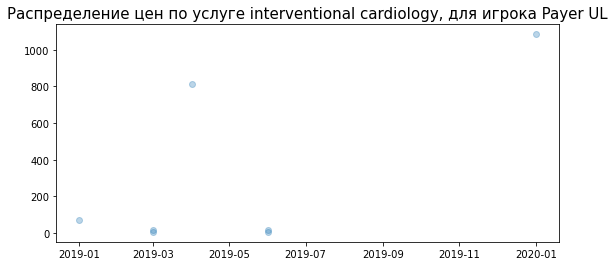

In [44]:
for cs in limit2:
    tmp_df = res_limit[res_limit.CLAIM_SPECIALTY == cs]
    for p in tmp_df.PAYER.unique():
        t = tmp_df[tmp_df.PAYER == p]
        fig, ax = plt.subplots(figsize=(9, 4))
        plt.title('Распределение цен по услуге {}, для игрока {}'.format(cs, p) 
                  , fontsize = 15)
        ax.scatter(t.MONTH, t.PAID_AMOUNT, alpha=0.3)
    plt.show()

<b>По сервисам

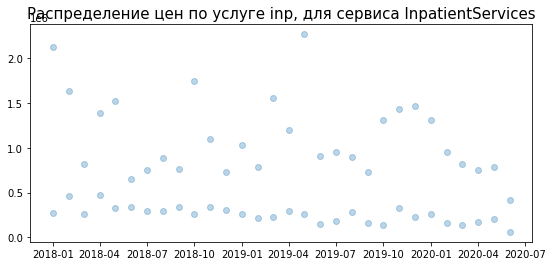

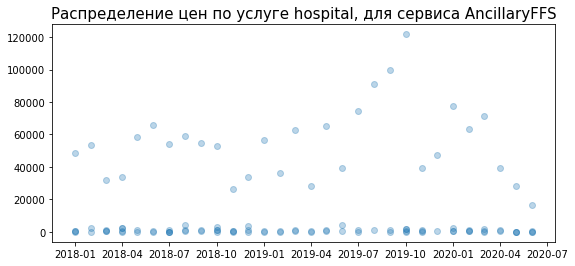

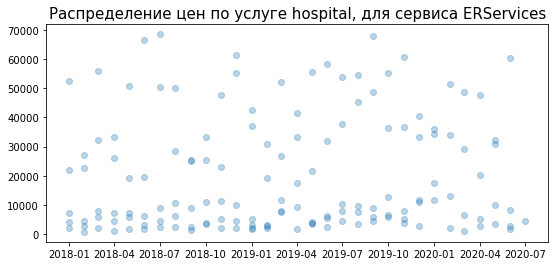

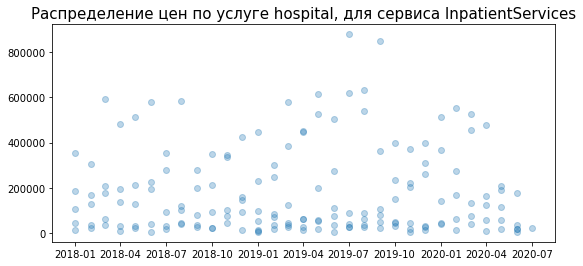

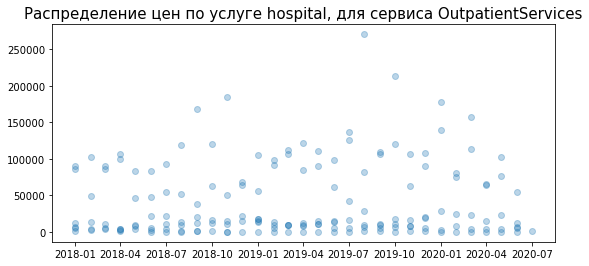

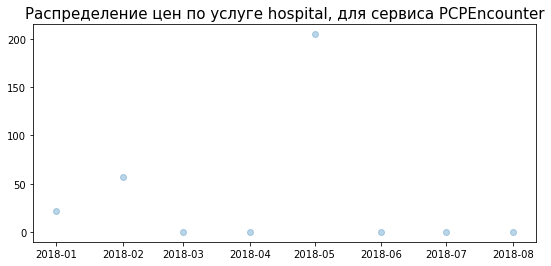

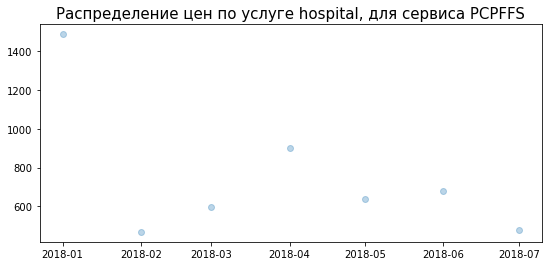

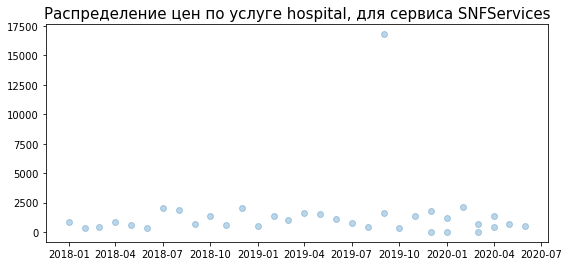

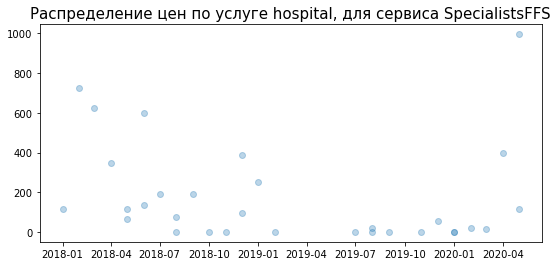

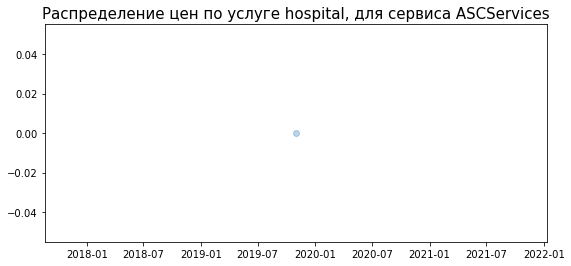

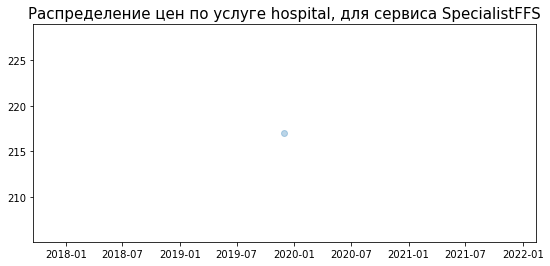

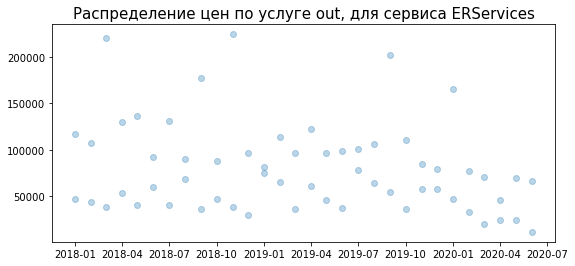

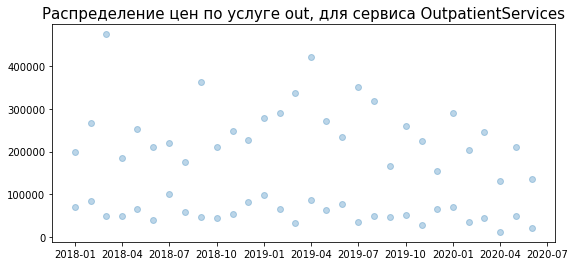

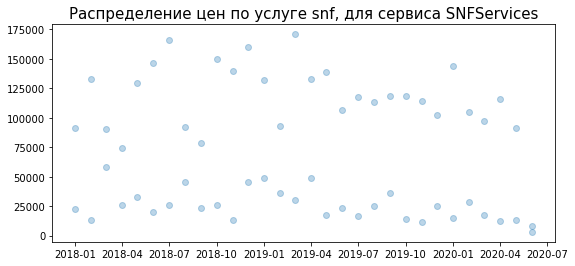

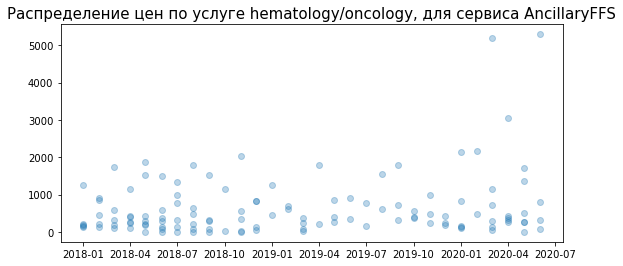

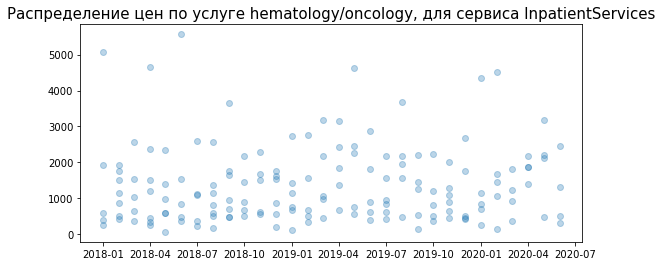

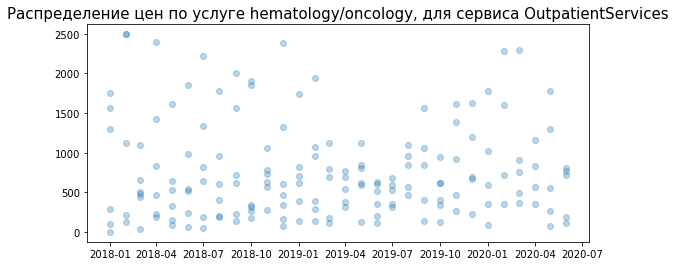

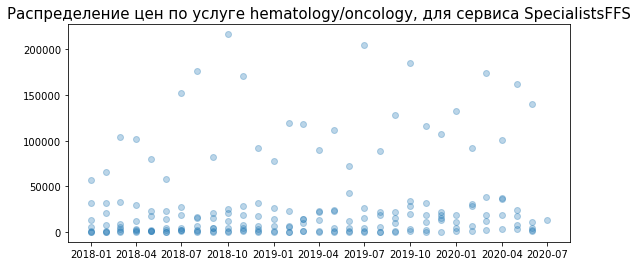

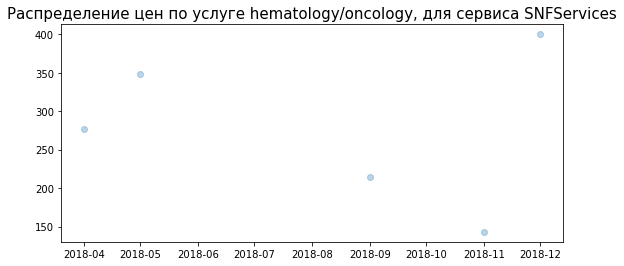

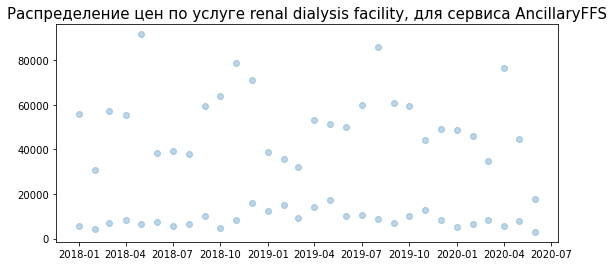

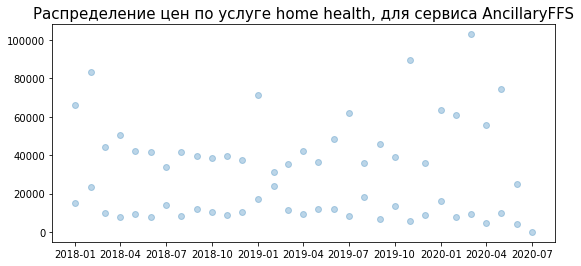

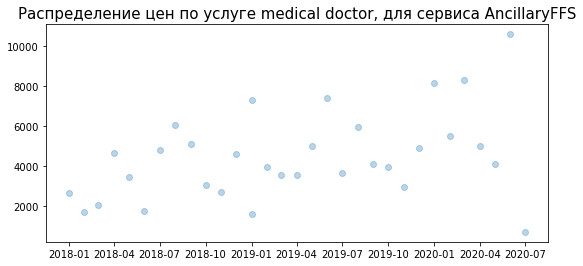

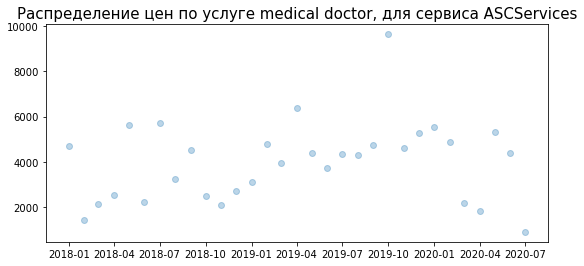

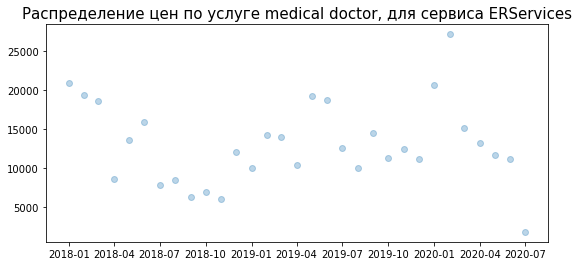

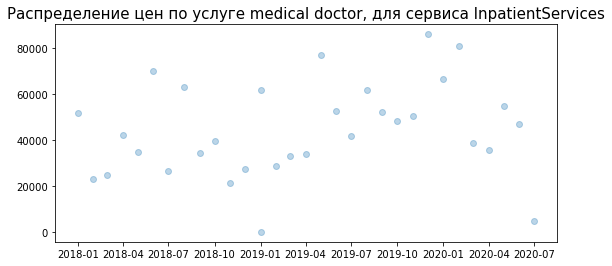

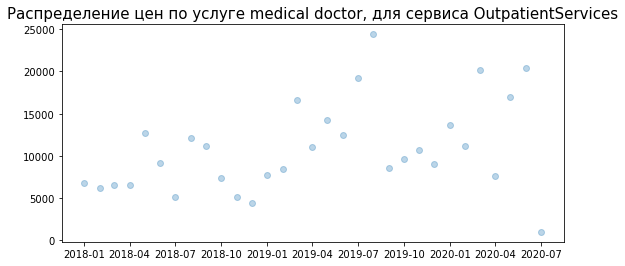

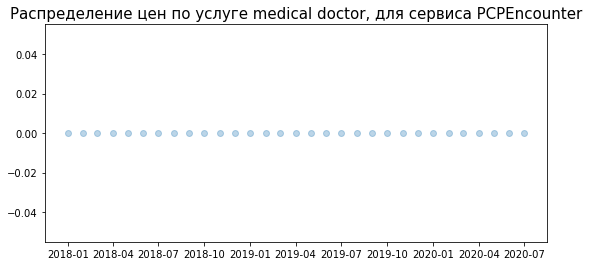

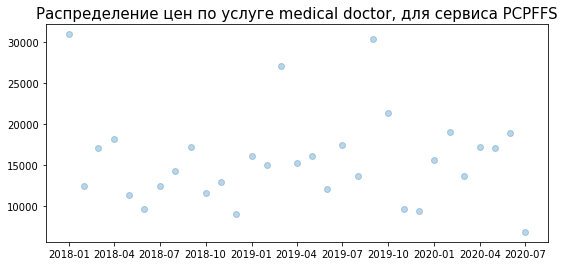

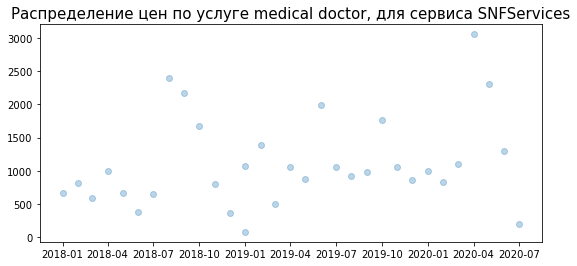

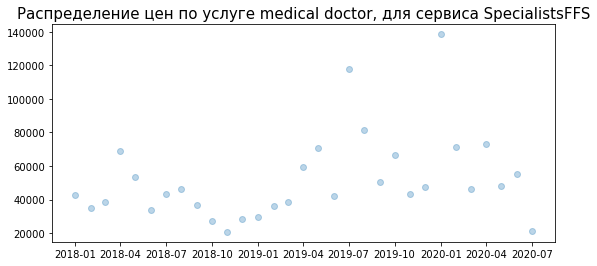

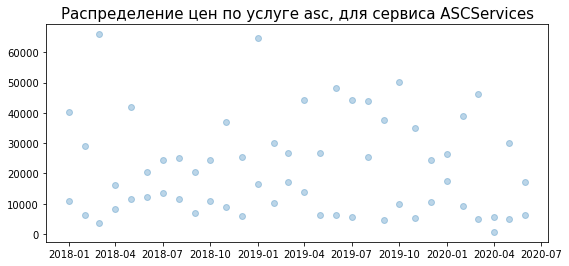

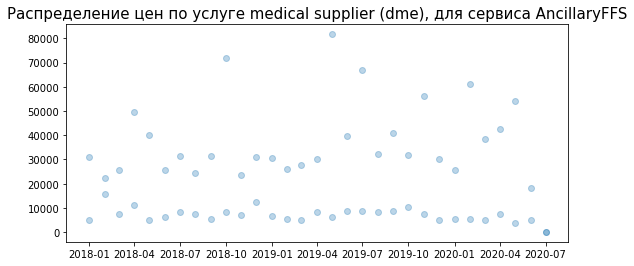

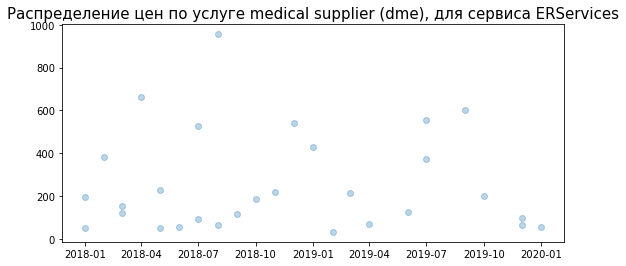

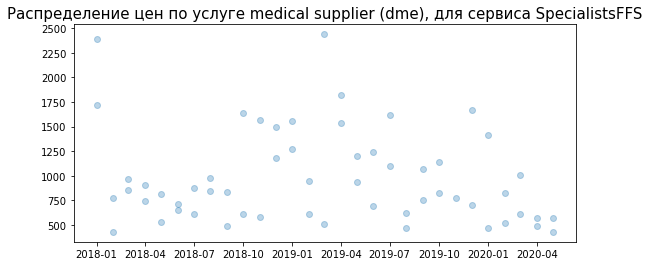

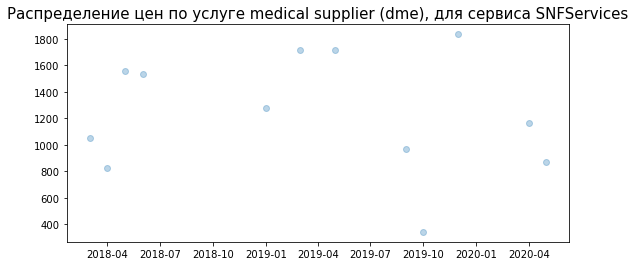

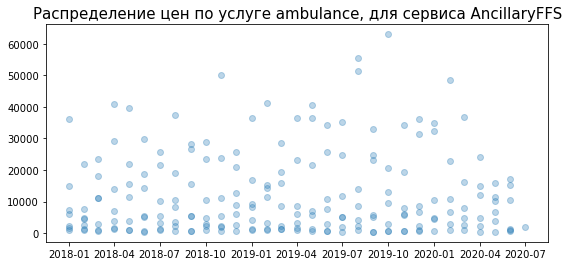

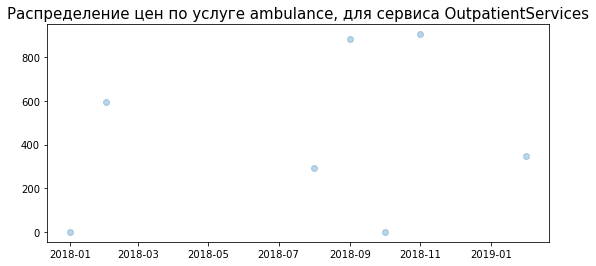

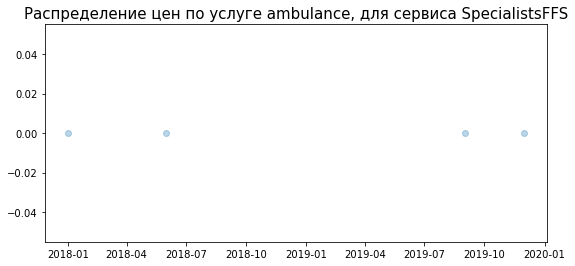

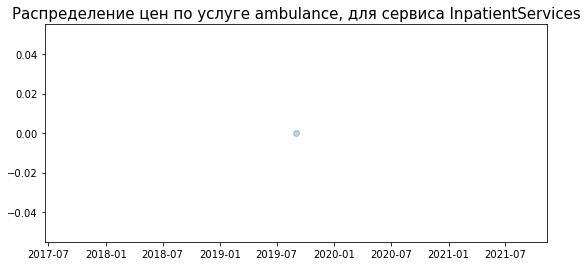

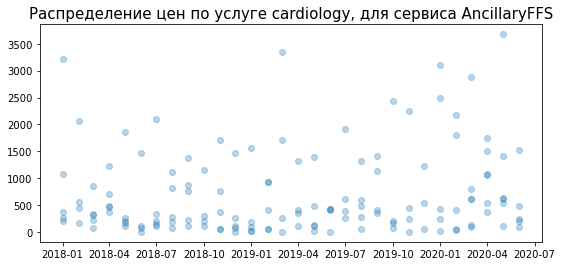

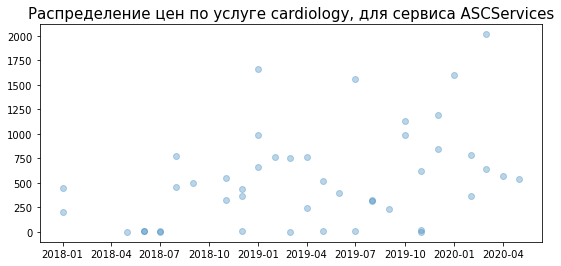

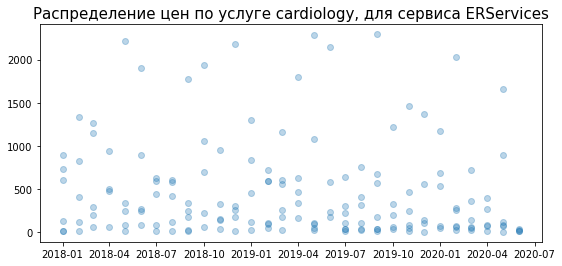

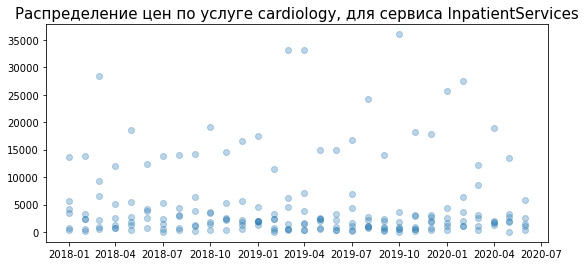

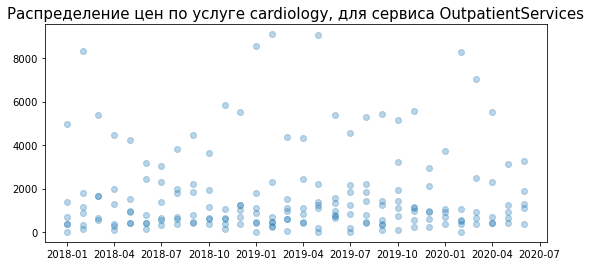

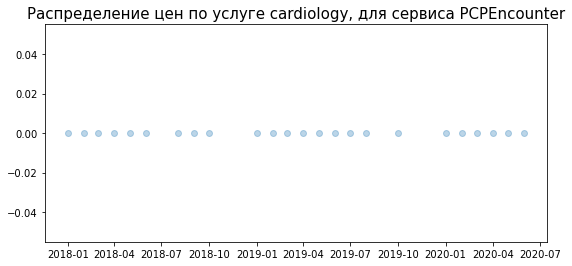

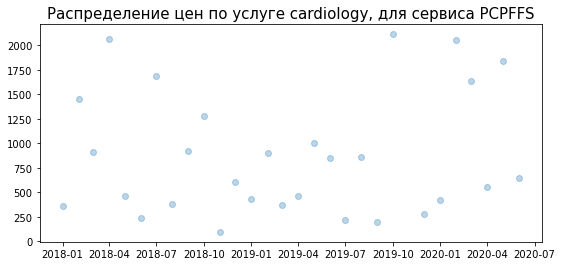

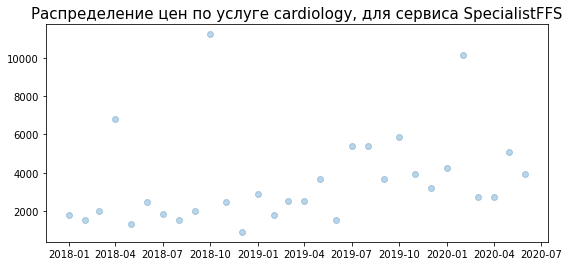

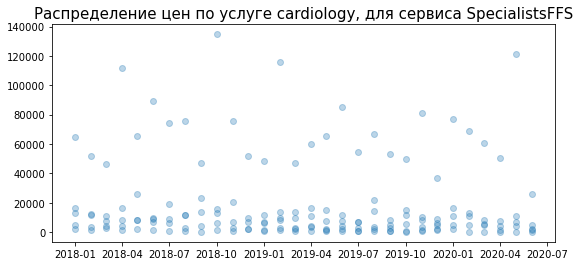

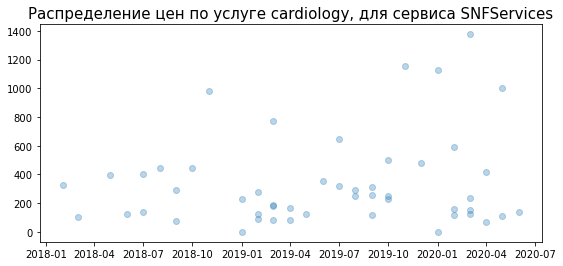

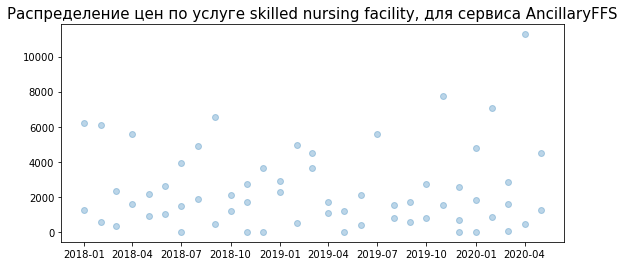

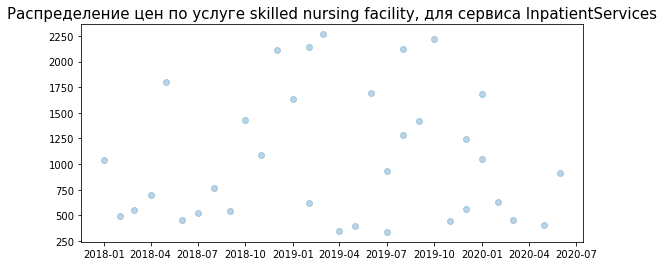

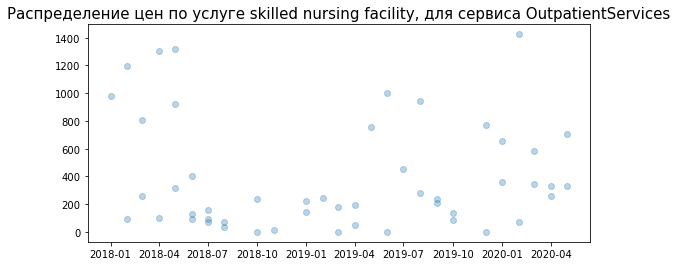

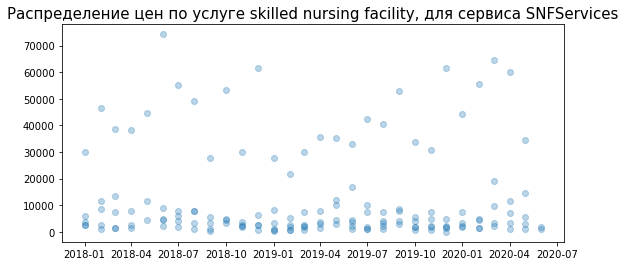

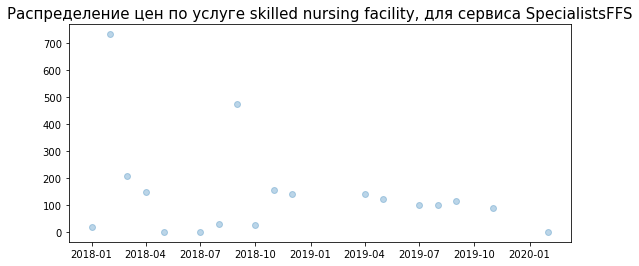

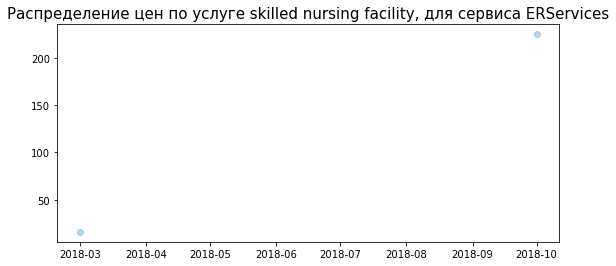

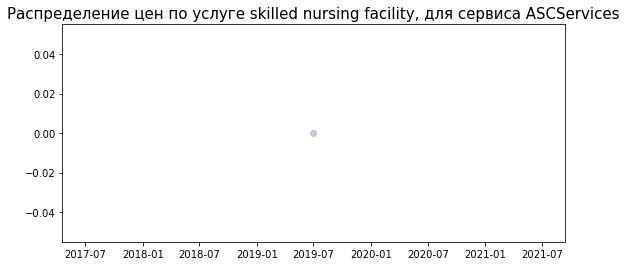

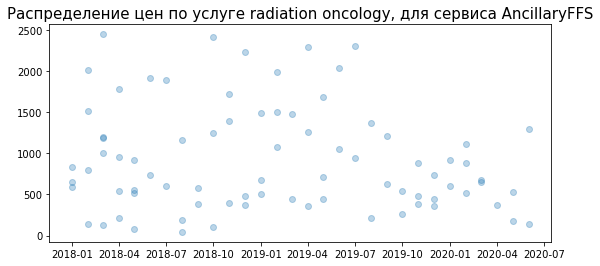

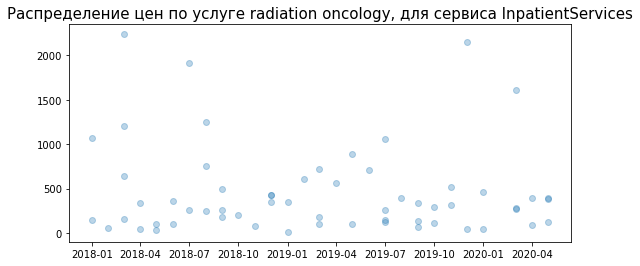

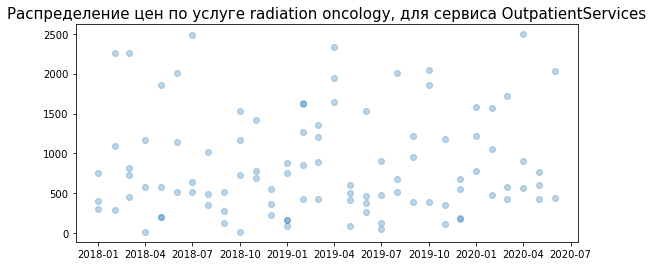

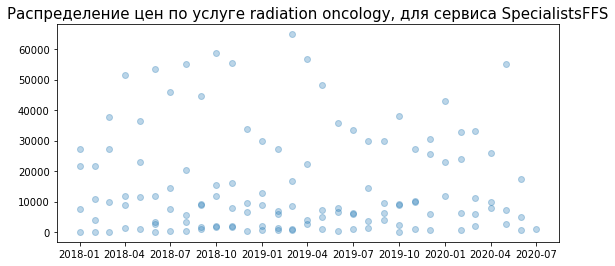

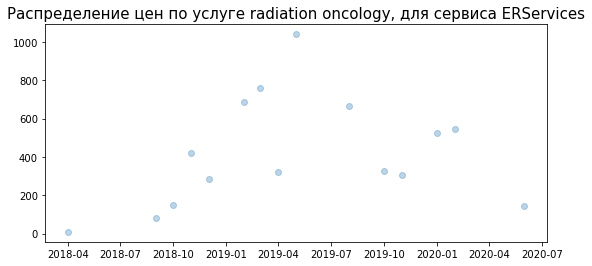

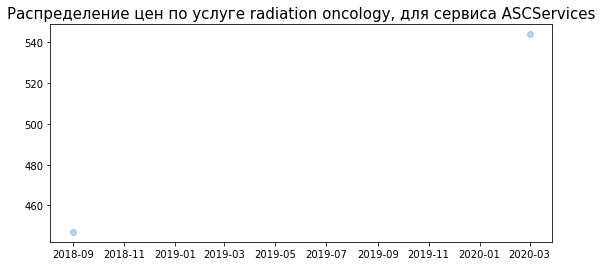

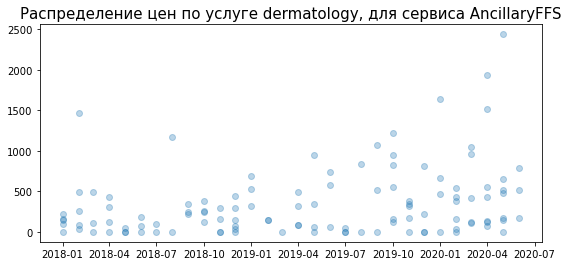

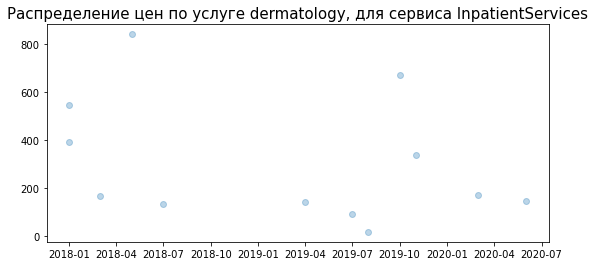

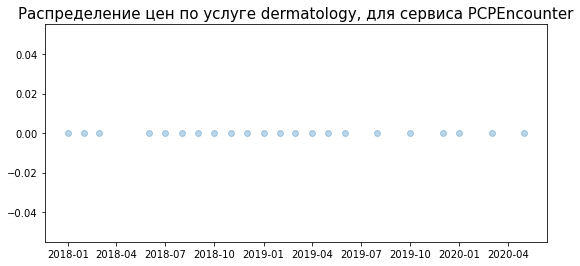

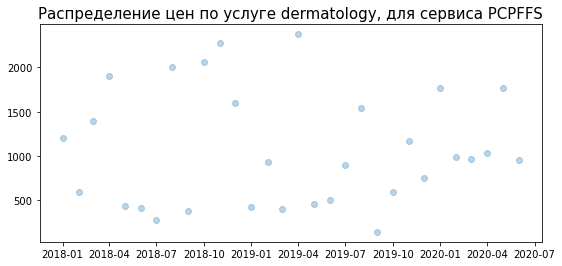

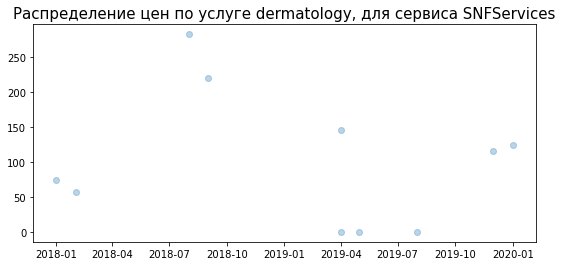

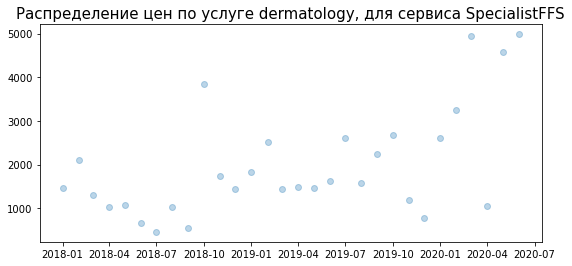

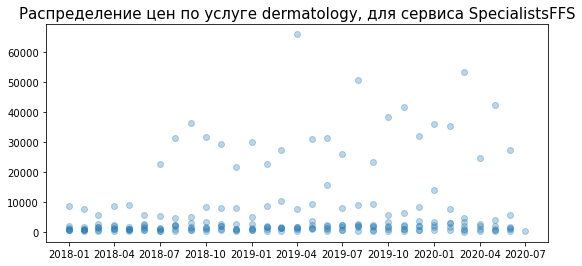

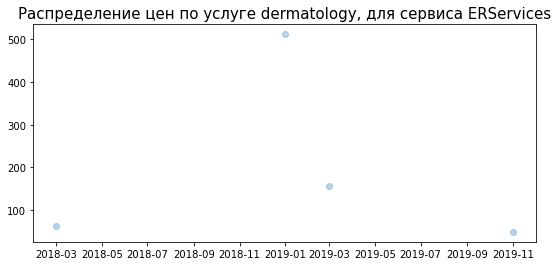

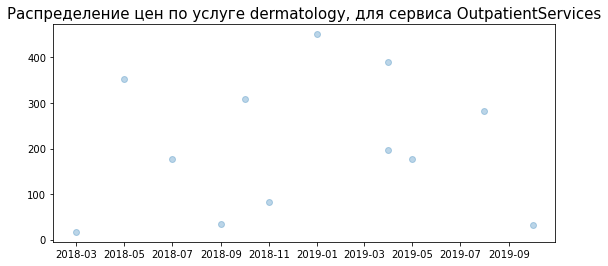

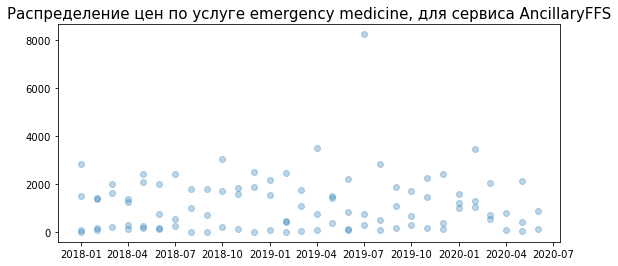

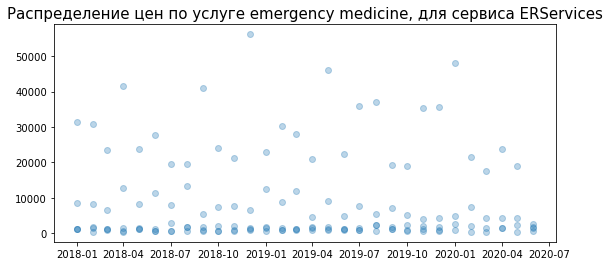

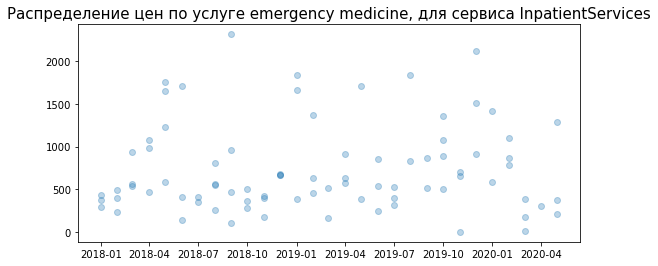

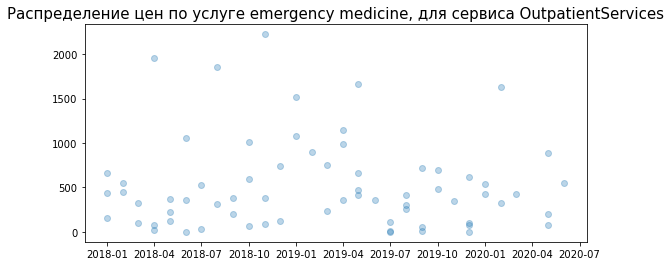

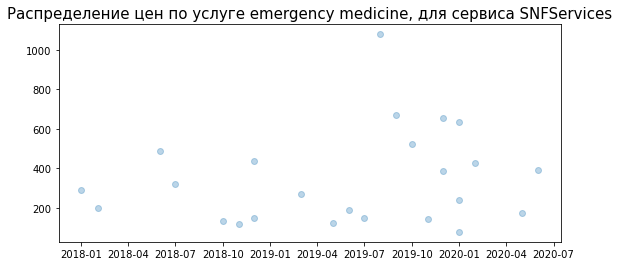

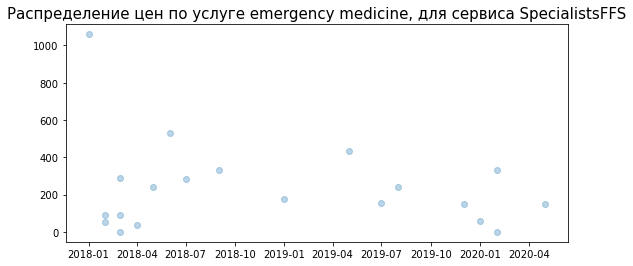

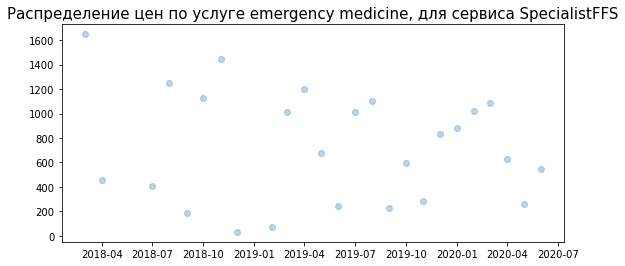

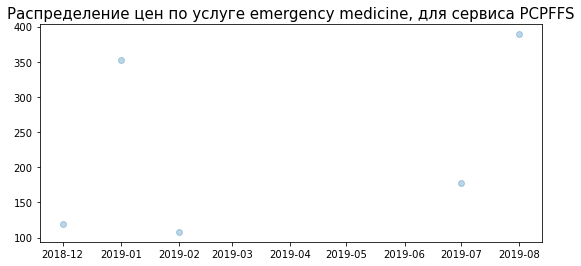

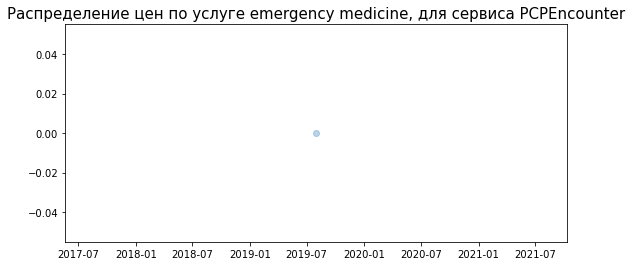

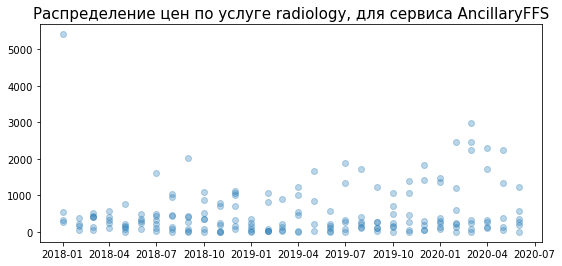

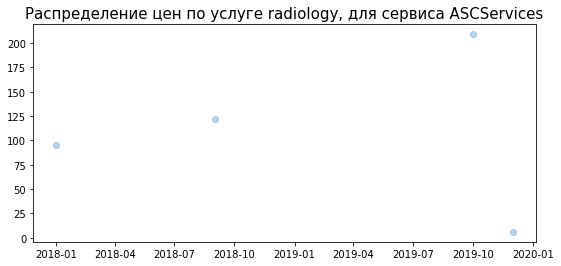

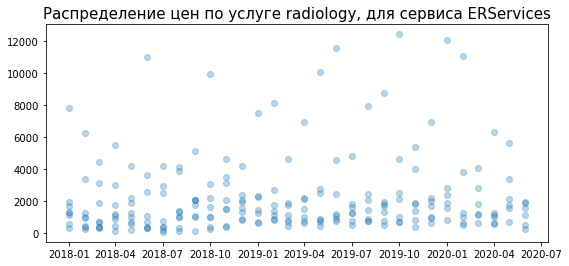

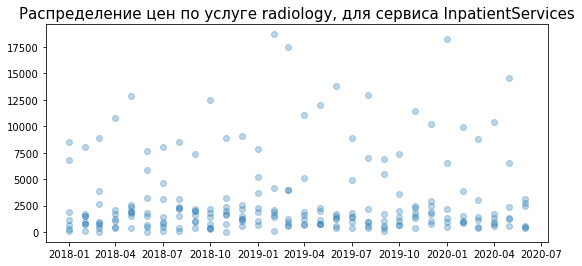

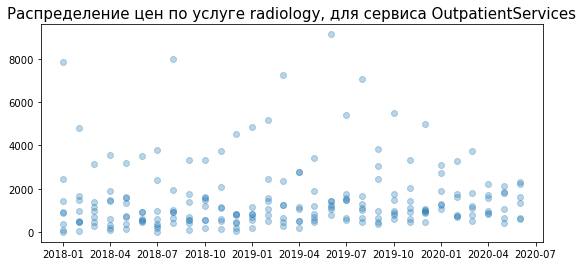

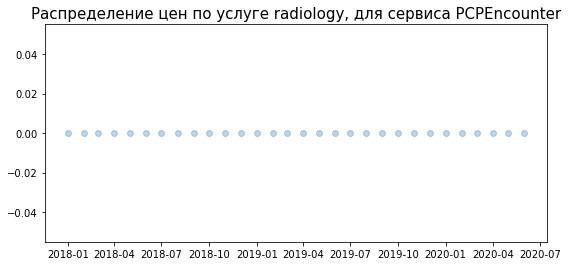

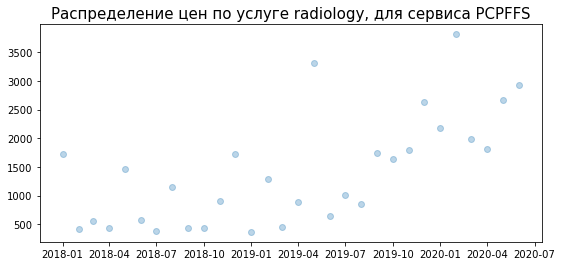

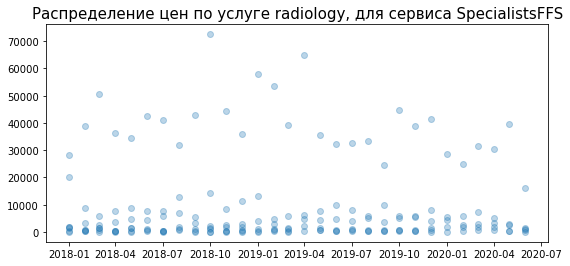

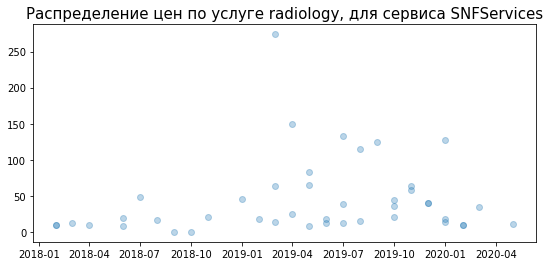

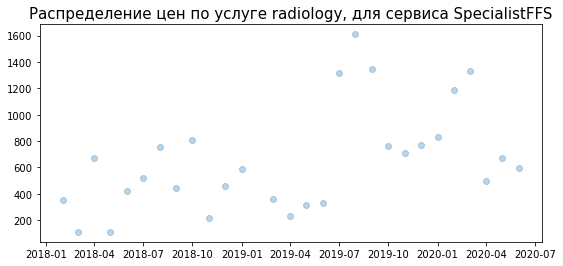

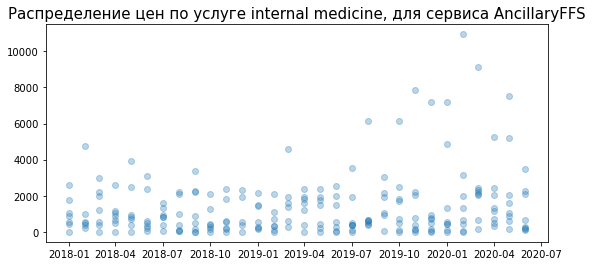

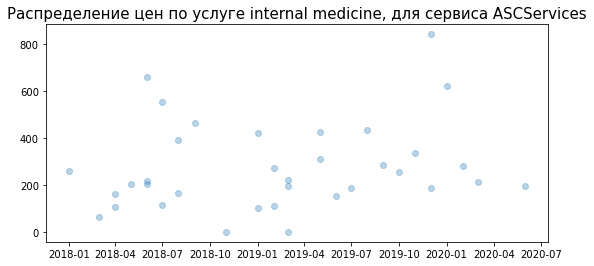

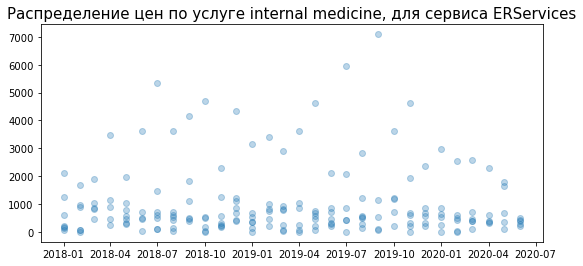

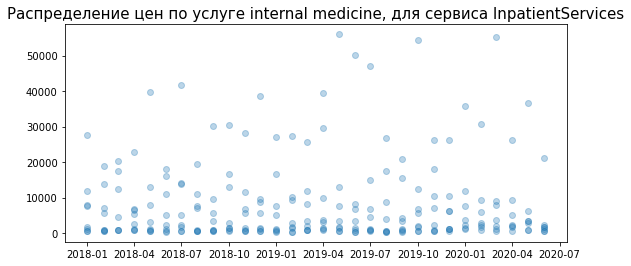

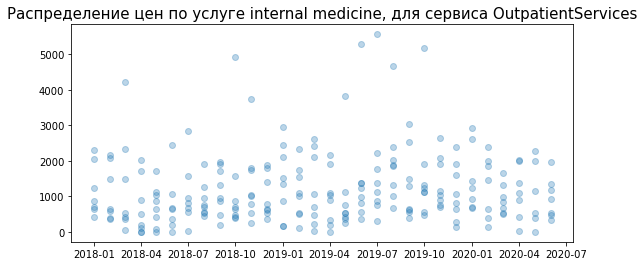

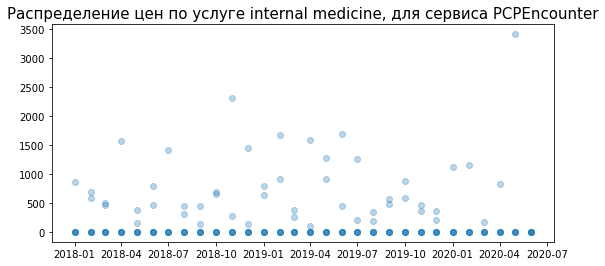

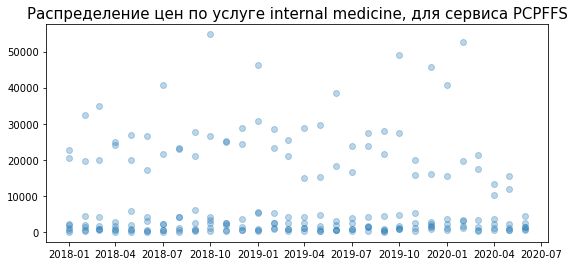

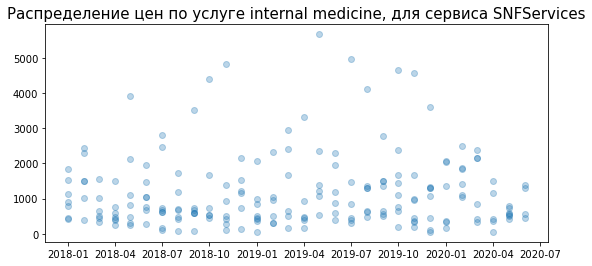

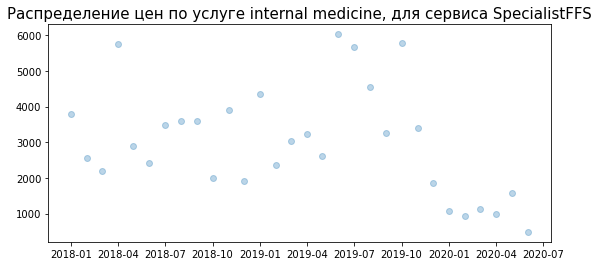

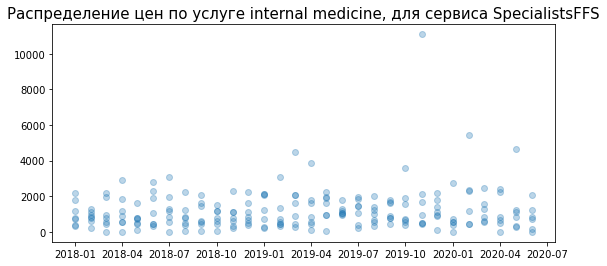

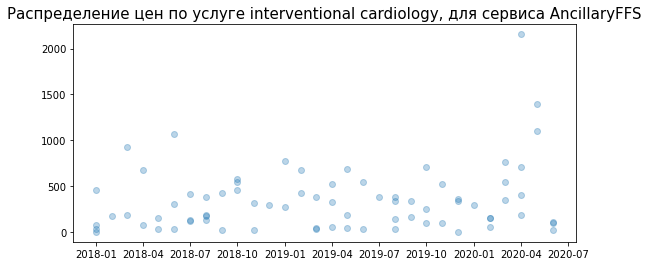

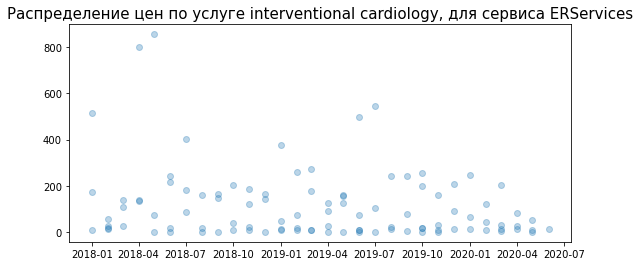

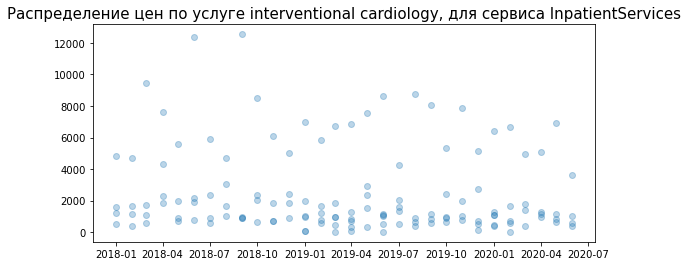

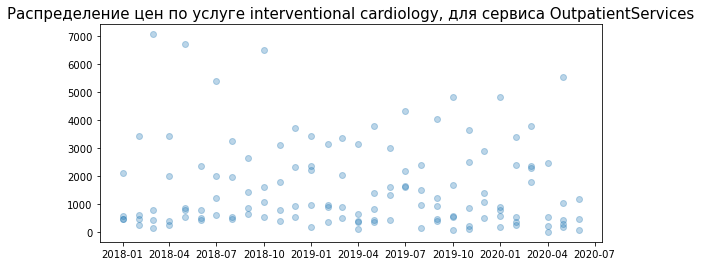

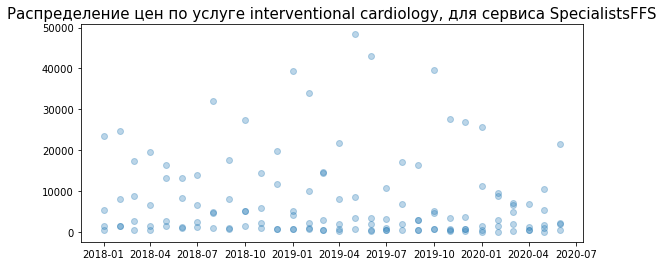

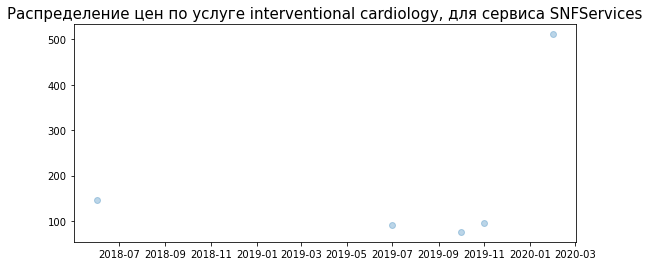

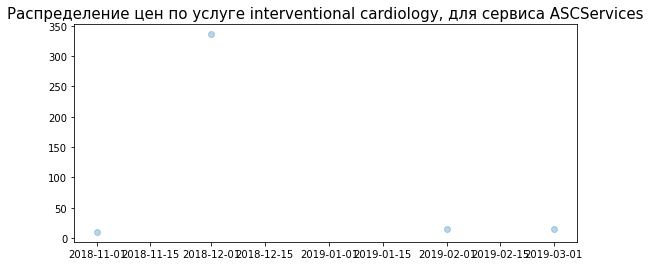

In [45]:
for cs in limit2:
    tmp_df = res_limit[res_limit.CLAIM_SPECIALTY == cs]
    for c in tmp_df.SERVICE_CATEGORY.unique():
        t = tmp_df[tmp_df.SERVICE_CATEGORY == c]
        fig, ax = plt.subplots(figsize=(9, 4))
        plt.title('Распределение цен по услуге {}, для сервиса {}'.format(cs, c) 
                  , fontsize = 15)
        ax.scatter(t.MONTH, t.PAID_AMOUNT, alpha=0.3)
    plt.show()

<b>Выводы
<ol>
<li>Самая затратная мед услуга IMP используется только двумя плательщиками F и O и только через сервис InpatientService. Сервис показывает тенденцию к снижению стоимости.
<li>Услуга medical doctor в рамках PCPEncounter, ambulance в SpecialistsFFS и InpatientService, cardiology в рамках PCPEncounter и dermatology в рамках PCPEncounter назначались только с нулевой стоимостью.


# Предсказания

<b>В отношении предсказаний. Учитывая, что все сервисы кроме одного показывают падение до нуля - тут нет  поля для предсказаний. Выглядит как конец бизнеса. Но, учитывая что за предыдущие периоды была стабильная статистика, можем представить что в последний месяц у нас была какая-то аномалия данных и мы еще в игре. 

In [46]:
agg = pd.DataFrame(df.groupby('MONTH')['PAID_AMOUNT'].agg('sum'))

In [47]:
def prediction (df_new, steps, title_add):
    df_new.index.freq = 'MS'

    model = sm.tsa.ARIMA(df_new, order=(1, 1, 1))
    results = model.fit()
    forecast = results.forecast(steps=steps)

    pd.set_option('display.float_format', '{:.2f}'.format)
    
    print(forecast)

    plt.figure(figsize=(12, 6))
    plt.plot(df_new.index, df_new['PAID_AMOUNT'], label='Исходные данные')
    plt.plot(pd.date_range(start=df_new.index[-1], periods=steps, freq='MS'), forecast, label='Прогноз', linestyle='--')
    plt.legend()
    plt.title('Прогноз PAID_AMOUNT, {}'.format(title_add))
    plt.xlabel('Дата')
    plt.ylabel('PAID_AMOUNT')
    plt.show()

2020-08-01   409557.64
2020-09-01   311652.63
2020-10-01   345990.70
2020-11-01   333947.36
2020-12-01   338171.30
2021-01-01   336689.85
Freq: MS, Name: predicted_mean, dtype: float64


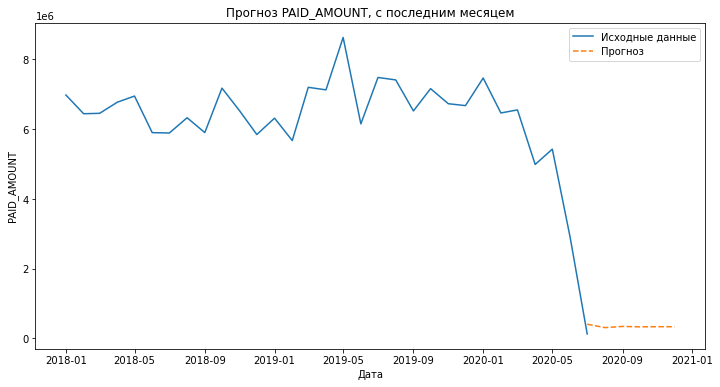

In [48]:
prediction(agg, 6, 'с последним месяцем')

2020-07-01   3506192.50
2020-08-01   3284291.67
2020-09-01   3367361.30
2020-10-01   3336263.79
2020-11-01   3347905.29
2020-12-01   3343547.24
2021-01-01   3345178.69
Freq: MS, Name: predicted_mean, dtype: float64


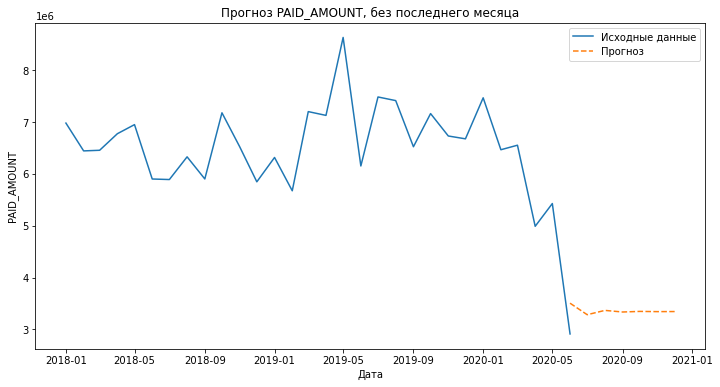

In [49]:
prediction(agg[:'2020-06-01'], 7, 'без последнего месяца')